**Assessing foraging landscape quality of commercial beekeeping in Quebec using remote sensing products, machine learning and survival analysis**
> Julien Vadnais, j.vadnais@umontreal.ca

> Liliana Perez, l.perez@umontreal.ca

> Nicolas Coallier, nico@nectar.buzz

# packages & libraries


Required:
* geopandas
* lifelines
* matplotlib
* numpy
* pandas
* scikit-learn
* scikit-survival
* scipy
* seaborn
* shapely


Optional:
* bioinfokit 
* rtree

In [ ]:
# Required
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import geopandas as gpd
import shapely
from geopandas.tools import sjoin
from shapely.geometry import Polygon, MultiPolygon

import scipy.spatial
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import r2_score

import lifelines
from lifelines import CoxTimeVaryingFitter

import sksurv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import cumulative_dynamic_auc

In [ ]:
# Optional
from adjustText import adjust_text
from bioinfokit.visuz import cluster
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import rtree
from sklearn.model_selection import GridSearchCV

# Datasets
Below are the dataset required to run this notebook 

**Beekeeping dataset** <br>
* QC colony reports 2021-2024

**Landscape metrics** <br>
*Based on a high-resolution remote-sensing crop map, metrics calculated in QGIS & ArcGIS Pro*
* 500-m buffer metrics
* 1000-m buffer metrics
* 2500-m buffer metrics
* 5000-m buffer metrics

**EVI data** <br>
*MODIS product extracted from GEE* 
* gdf_eo geojson file

**Elevation data** <br>
*DEM extracted from GEE* 
* In notebook

## Beekeeping dataset

In [ ]:
# QC beekeeping reports 2021-2024
gdf = gpd.read_file(r'path',crs='EPSG:4326')
gdf.head()

In [ ]:
# date column to datetime format
gdf['date'] = pd.to_datetime(gdf['report_submitted_at'], utc=True)

# Creates a 'year' column 
gdf['year'] = gdf['date'].dt.year

gdf.head()

In [ ]:
gdf.isna().any()

In [ ]:
# dropping columns which won't be used here
gdf.drop(columns={'report_submitted_at','category','crop_type','lat','lon','action_detail'},inplace=True,errors='ignore')

#renaming ID columns
gdf.rename(columns={'hive_identity_id':'hiveID','operation_id':'operationID'},inplace=True,errors='ignore')

In [ ]:
gdf.dtypes

In [ ]:
# Converting to integer column type
gdf[['hiveID','operationID','is_alive','hive_age']] = gdf[['hiveID','operationID','is_alive','hive_age']].astype(int)

In [ ]:
# explore the dataset
print('# Hive IDs:',gdf['hiveID'].nunique())
print('# operation IDs:',gdf['operationID'].nunique())

### Computing E and T

Survival analysis typically requires two features: E and T.
In our case,
* **E**, the event, indicates whether or not a colony has been reported dead in the data.
* **T**, the time until the event, is calculated the number of days until a hive has or has not been reported dead following its first report

#### Compute the event (E)

First, we compute the **E** event column 

In [ ]:
# empty column to store the event values
gdf['E'] = None

# for loop to report last 'is_alive' value
for id in gdf['hiveID'].unique():
    # sorts values for each unique ID and gets the latest (last idx) 'is_alive' value
    temp = gdf.loc[gdf['hiveID'] == id].sort_values(by='date').iloc[-1]['is_alive']
    # If the last 'is_alive' value is 1, invert and set E to 0, if it is no, set E to 1
    gdf.loc[gdf['hiveID'] == id, 'E'] = abs(temp - 1)

In [ ]:
gdf.loc[0]

In [ ]:
gdf = gdf.sort_values(by=['hiveID','date'])
gdf.head()

In [ ]:
gdf.loc[gdf['hiveID']==12451].loc[gdf['is_alive']==0]

Check for 'false' or 'second' events

In [ ]:
# # y2 is a dummy column to compare with E. This allows to check if a hiveID can be reported alive after being reported dead once.

# gdf['y2'] = None

# # Same as preceding loop but y2 = 0 if ANY 'is_alive' = 0
# for i in gdf['hiveID'].unique():
#     # sorts values for each unique ID and gets the latest (last idx) 'is_alive' value
#     temp = gdf.loc[gdf['hiveID'] == i]['is_alive'].min()
#     gdf.loc[gdf['hiveID'] == i, 'y2'] = abs(temp -1)

# gdf['y2'].value_counts()

In [ ]:
gdf['E'].value_counts()

In [ ]:
# It is perfect to see that no colonies has been reported alive after being reported dead. We can remove y2 column
gdf.drop(columns='y2',inplace=True,errors='ignore')

Removing reports after the event. <br>
Some beekeepers might report a hive after it's been reported dead already. We don't need these additional reports.

In [ ]:
# creates a list comprising the first event report for each hiveID
event_indices = gdf[gdf['is_alive'] == 0].groupby('hiveID')['date'].idxmin()
event_indices

In [ ]:
# Creates a boolean masking array. For each index, the values of hiveID and the index is compared to have a true/false value.
bool_array = gdf.index <= gdf['hiveID'].map(event_indices)
bool_array

In [ ]:
# Applies the masking array to keep only those with a 'True' value 
gdf = gdf[bool_array | gdf['hiveID'].map(event_indices).isna()].copy()

In [ ]:
# resets the index and drops the old one
gdf = gdf.reset_index(drop=True)

gdf.head(n=40)

#### Compute the time (T)

We can compute the **T** value by calculating the difference between the first and the last report, for each hiveID. <br>
It must not be confused with the 'hive_age' feature in the dataset, which was previously computed, and which represents the punctual hive_age at a report.

In [ ]:
# create empty column
gdf['T'] = None

# for loop to calculate total days reported alive
for id in gdf['hiveID'].unique():
    diff = gdf.loc[gdf['hiveID'] == id, 'date'].max() - gdf.loc[gdf['hiveID'] == id, 'date'].min()
    gdf.loc[gdf['hiveID'] == id, 'T'] = diff

In [ ]:
gdf.head()

In [ ]:
# converting to integer format the number of days alive
gdf['T'] = gdf['T'].apply(lambda x: x.days)

In [ ]:
gdf.head()

Removing 'one-report' hives

In [ ]:
# 763 hives have been reported only once. Therefore they don't have value for survival analysis.
gdf[gdf['T']==0]['hiveID'].nunique()

In [ ]:
gdf[gdf['T'] > 0]['hiveID'].nunique()

In [ ]:
# From 18054 to 17291. We can remove those only reported once.
gdf = gdf[gdf['T'] > 0]

## Landscape metrics

### Landscape Shannon diversity Index (SDI) and richness

#### 500-m buffer

In [ ]:
# reading the file
metrics500 = gpd.read_file(r'path.geojson')
metrics500.columns

In [ ]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics500['lon'], metrics500['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics500, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column 
gdf_temp.rename(columns={'Div_sh':'sdi_500','MAJORITY':'maj_500','VARIETY':'rich_500'},inplace=True,errors='ignore')

In [ ]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_500','maj_500','rich_500']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

In [ ]:
#Nan check
gdf.isna().sum()

#### 1000-m buffer

In [ ]:
metrics1000 = gpd.read_file(r'path.geojson')
metrics1000.columns

In [ ]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics1000['lon'], metrics1000['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics1000, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_1000','_majority':'maj_1000','_variety':'rich_1000'},inplace=True,errors='ignore')


In [ ]:
gdf_temp['geometry'].nunique()

In [ ]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_1000','maj_1000','rich_1000']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

In [ ]:
#Nan check
gdf.isna().sum()

#### 2500-m buffer

In [ ]:
metrics2500 = gpd.read_file(r'path.geojson')
metrics2500.columns

In [ ]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics2500['lon'], metrics2500['lat'])]

# temp gdf to merde landscape metrics at 2500m
gdf_temp = gpd.GeoDataFrame(metrics2500, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_2500','_majority':'maj_2500','_variety':'rich_2500'},inplace=True,errors='ignore')


In [ ]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_2500','maj_2500','rich_2500']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

In [ ]:
#Nan check
gdf.isna().sum()

#### 5000-m buffer

In [ ]:
metrics5000 = gpd.read_file(r'path.geojson')
metrics5000.columns

In [ ]:
# needed to convert to point geometry
geometry = [Point(lon, lat) for lon, lat in zip(metrics5000['lon'], metrics5000['lat'])]

# temp gdf to merde landscape metrics at 1000m
gdf_temp = gpd.GeoDataFrame(metrics5000, geometry=geometry, crs='EPSG:4326')

#Rename the Shannon Diversity Index (SDI) column and the majority (dominant crop type in buffer)
gdf_temp.rename(columns={'Div_sh':'sdi_5000','_majority':'maj_5000','_variety':'rich_5000'},inplace=True,errors='ignore')


In [ ]:
# spatial join
gdf = gpd.sjoin(gdf, gdf_temp[['geometry','sdi_5000','maj_5000','rich_5000']], how='left')
gdf.drop(columns='index_right', inplace=True,errors='ignore')
gdf.head()

In [ ]:
#Nan check
gdf.isna().sum()

## Enhanced vegetation index (EVI) data

We pre-calculated a series of EVI data. This was retrieved using google earth engine from a MODIS products. If you would like to run the retrieving process, please see ***Appendix 1***. Consider 1-2 hours for the whole process.

In [ ]:
gdf_eo = gpd.read_file(r'path',crs='EPSG:4326')
gdf_eo.crs

In [ ]:
# We shall only use the Enhanced Vegetation Index.
gdf_eo.drop(columns={'fpar_apr','fpar_jul','fpar_oct','lai_apr','lai_jul','lai_oct'},inplace=True,errors='ignore')
gdf_eo['geometry'].nunique()

### Spatial join

we import a spatial index tool to speed up spatial joins

In [ ]:
# reimport fix
import geopandas
import rtree

# creates a spatial index using geopandas.sindex and rtree
sindex = gdf_eo.sindex

# spatial index check
gdf_eo.has_sindex

With the spatial index created, this shouldn't take more than a few seconds

In [ ]:
# Perform the spatial join (uses the spatial index)
gdf = sjoin(gdf, gdf_eo, how='left')

# Na values check
gdf.isna().any()

In [ ]:
gdf.drop(columns='index_right',inplace=True,errors='ignore')

In [ ]:
gdf.head()

## Topographic data

Additional topographic data can add another quantitative characteristic to describe the foraging landscape

The Canadian Digital Elevation Model (CDEM) Product covers our study, and its use has been well proven. Source: Canada Centre for Mapping and Earth observation, Natural Resources Canada (2013). url: https://ftp.geogratis.gc.ca/pub/nrcan_rncan/elevation/cdem_mnec/doc/CDEM_product_specs.pdf

In [ ]:
# earth engine 
ee.Authenticate()

In [ ]:
ee.Initialize(project='"project_path"')

In [ ]:
# Creates a unique geometry gdf to avoid redundancy
ugdf = gdf.drop_duplicates(subset='geometry')

In [ ]:
# function for elevation
def get_elevation(point):
  poi = ee.Geometry.Point(point.x, point.y)
  
  collection = ee.ImageCollection('NRCan/CDEM').filterBounds(poi)
  scale = 30  # ee says 23 m resolution but to vary between 20 and 30+ m depending on latitudes

  # Extract elevation at point location
  elev = collection.first().sample(poi, scale).first().get('elevation').getInfo()

  #print(elev)

  return elev

Alongside raw elevation, we can compute the std dev of elevation in a buffer to assess whether the location is a rather hilly or flat landscape

In [ ]:
# function for std of elevation
def get_std_dev_elevation(point):
        # Need to convert to Earth Engine geometry
        poi = ee.Geometry.Point([point.x, point.y])
        
        # Define a 300m buffer around the point
        buffer = poi.buffer(300)  # Buffer in meters
        
        # select the NRCAN DEM image collection
        collection = ee.ImageCollection('NRCan/CDEM').filterBounds(buffer)
        image = ee.Image(collection.first())
        
        # Compute statistics within the buffer region
        stats = image.reduceRegion(
            reducer=ee.Reducer.stdDev(),
            geometry=buffer,
            scale=30,  # ee says 23 m resolution but to vary between 20 and 30+ m depending on latitudes
        )
        
        # Extract the standard deviation value
        std_dev = stats.get('elevation').getInfo()
        
        return std_dev

# Apply to function to unique geometry gdf
ugdf['elevation_std_dev'] = ugdf['geometry'].apply(lambda point: get_std_dev_elevation(point))

6 mins

In [ ]:
# Get elevations for each point in the GeoDataFrame
ugdf['elevation'] = ugdf['geometry'].apply(lambda point: get_elevation(point))

In [ ]:
ugdf.head(n=30)

In [ ]:
sindex = ugdf.sindex

In [ ]:
ugdf.has_sindex

In [ ]:
# Perform the spatial join (uses the spatial index)
gdf = sjoin(gdf, ugdf[['geometry','elevation','elevation_std_dev']], how='left',)

# Na values check
gdf.isna().any()

In [ ]:
gdf['elevation'] = gdf['elevation'].astype(int)

In [ ]:
print(f'mean elevation of reports : {gdf['elevation'].mean()}')
print(f'median elevation of reports : {gdf['elevation'].median()}')
print(f'min elevation of reports : {gdf['elevation'].min()}')
print(f'max elevation of reports : {gdf['elevation'].max()}')

In [ ]:
backup_1 = gdf.copy()

In [ ]:
# backup_1.to_file(r'path.geojson',driver='GeoJSON')

# Backup 1
Run below to use backup

In [ ]:
gdf = backup_1.copy()

In [ ]:
gdf.isna().any()

# Feature engineering

In [ ]:
# reorder columns
gdf = gdf[['hiveID','year','date','operationID','is_alive','E','T','hive_age',
           'maj_500','maj_1000','maj_2500','maj_5000',
           'rich_500','rich_1000','rich_2500','rich_5000',
           'sdi_500','sdi_1000','sdi_2500','sdi_5000',
           'evi_apr','evi_jul','evi_oct',
           'elevation','elevation_std_dev',
           'geometry']]

In [ ]:
gdf.head()

## Time-weighted average (TWA)

Beehives used in commercial beekeeping often get moved during the beekeeping season to fulfill pollination contracts. <br>
Here, we account for this movement by calculating a Time-Weighted Average (TWA) of the landscape metrics of each location that a colony met during its lifetime. 

The proceding steps are as follows:
* Make sure the df is ordered properly
* Calculate the time interval between each reports for a same hive
* Calculate the TWA value for each metrics

### Ordering the df

First, we want to order correctly the reports.

We can order solely by hiveID and 'date' since the 'date' feature includes the hour of report!

In [ ]:
#Sorts the gdf by hiveID and time of report
gdf = gdf.sort_values(['hiveID','date'])
gdf = gdf.reset_index(drop=True)
gdf.head()

In [ ]:
# Let's drop duplicate reports
gdf = gdf.drop_duplicates(['hiveID','date','geometry','is_alive'])

### Calculate report time intervals

In [ ]:
# We calculate the time_interval as absolute between reports  of the same hiveID. We fill the NaN (last reports of each group) with a value of 0 days
gdf.loc[:,'time_interval'] = gdf.groupby('hiveID')['date'].transform(lambda x: abs(x.diff(periods=-1)).fillna(pd.Timedelta(0)))
gdf.head()

In [ ]:
gdf['time_interval'].min()

This looks good. However, what happens in the winter? <br>

In [ ]:
# Check for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

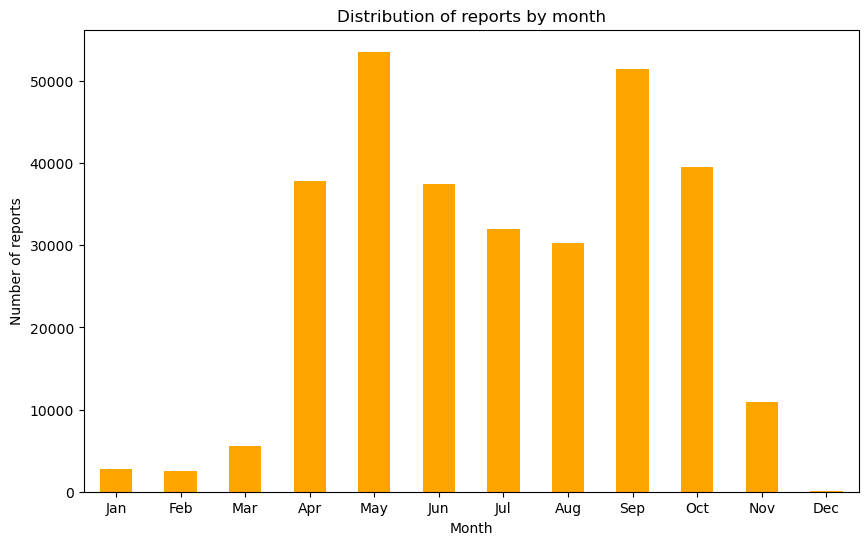

In [ ]:
# creates a month column
gdf['month'] = gdf['date'].dt.month

# creates a monthly distribution count 
monthly_distribution = gdf['month'].value_counts().sort_index()

# Plot the distribution count per months
plt.figure(figsize=(10, 6))
monthly_distribution.plot(kind='bar', color='orange')
plt.title('Distribution of reports by month')
plt.xlabel('Month')
plt.ylabel('Number of reports')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

In Quebec, hives are wintered and stop foraging. Therefore, we must not account for the landscape metrics during the winter months. <br>
Looking at the last report of the season on August 17, we see that the time_interval is overestimated with 195 days. Let's fix that

Since we are assessing foraging landscape quality, let's define limit days to account only for the beekeeping season. <br> We'll use November 15 as the latest date and March 1st as the earliest date.

In [ ]:
# Check reports made after the end of the beekeeping season
gdf.loc[(gdf['date'].dt.month == 11) & (gdf['date'].dt.day > 15) | (gdf['date'].dt.month == 12),'date']

In [ ]:
# Check reports made before the start of the beekeeping season
gdf.loc[(gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1),'date']

In [ ]:
# Creates a boolean mask to select the reports made after November 15 of the year
bool_mask = ((gdf['date'].dt.month == 11) & (gdf['date'].dt.day > 15)) | (gdf['date'].dt.month == 12)

# Applies a lambda function on the masked reports to change the date to Nov 15 of the same year
gdf.loc[bool_mask, 'date'] = gdf.loc[bool_mask, 'date'].apply(lambda x: pd.Timestamp(f'{x.year}-11-15 23:59:00', tz='UTC'))


In [ ]:
# Check the difference
gdf.loc[(gdf['date'].dt.month == 11) & (gdf['date'].dt.day >= 15) | (gdf['date'].dt.month == 12),'date']

We can repeat this for reports made early in the year, in winter months. Let's deplace them to March 1st

In [ ]:
# Creates a boolean mask to select the reports made before March of the year
bool_mask = (gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1)

# Applies a lambda function on the masked reports to change the date to March 1st of the same year
gdf.loc[bool_mask, 'date'] = gdf.loc[bool_mask, 'date'].apply(lambda x: pd.Timestamp(f'{x.year}-03-01 00:00:01', tz='UTC'))


In [ ]:
# Check the difference
gdf.loc[(gdf['date'].dt.month == 2) | (gdf['date'].dt.month == 1),'date']

In [ ]:
# Check new monthly distribution
gdf['month'] = gdf['date'].dt.month
monthly_distribution

Now, let's recalculate the time_intervals.

In [ ]:
# We calculate the time_interval as absolute between reports  of the same hiveID. We fill the NaN (last reports of each group) with a value of 0 days
gdf.loc[:,'time_interval'] = gdf.groupby('hiveID')['date'].transform(lambda x: abs(x.diff(periods=-1)).fillna(pd.Timedelta(0)))

# Check for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

We now should fix the time_interval for cases such as hive 12531 (195 days)

In [ ]:
# We define a function to calculate the time difference with November 16st
def calc_diff_with_nov(group):
    # Extracts the year from the group index
    year = group.name[1]  # The 'year' is the second element in the tuple if the index is ('hiveID', 'year')
    
    # Calculates November 16 of the given year for all rows.
    latest_date = pd.Timestamp(f'{year}-11-16', tz='UTC')
    
    # Calculate the difference in days for the last report of each group
    group.loc[group.index[-1], 'time_interval'] = (latest_date - group['date'].iloc[-1])
    
    return group

# applies the function to each group and drops the grouping index
gdf = gdf.groupby(['hiveID', 'year']).apply(calc_diff_with_nov)
gdf = gdf.reset_index(drop=True)

In [ ]:
# New check, after fix, for a hive that is wintered over a season
gdf[gdf['hiveID']==12531]

In [ ]:
gdf['time_interval'].min()

While the interval of the fall last report is fixed, we can see the last report is messed up. The last report, whether it indicates a colony death or not, should have a time_interval of 0.

In [ ]:
# For each hiveID, set the time_interval of the last report to 0.
gdf['time_interval'] = gdf.groupby('hiveID')['time_interval'].transform(lambda x: x.where(x.index != x.index[-1], pd.Timedelta(0)))

# Recheck
gdf[gdf['hiveID']==12531]

This seems right

In [ ]:
gdf['time_interval'].min()

In [ ]:
# We convert the time_interval column to integer as the number of days
gdf.loc[:,'time_interval'] = gdf['time_interval'].dt.days.astype(int)
gdf.dtypes

In [ ]:
# # For an overlook of the data
# gdf.head(n=50)

In [ ]:
# # Check for a given hive
# gdf[gdf['hiveID']==55976]

### Computing TWA metrics

#### TWA landscape richness

In [ ]:
# sdi column list
rich_columns = ['rich_500','rich_1000','rich_2500','rich_5000']

# make sure it is in the right format
for col in rich_columns:
  gdf[col] = gdf[col].astype(int)

In [ ]:
# Function to calculate TWA_rich for each hive
def calculate_twa_rich(group):
    for col in rich_columns:
        # Compute the weighted sum of EVI and total time_interval for the group
        weighted_sum_rich = (group[col] * group['time_interval']).sum()
        total_time = group['time_interval'].sum()
        
        # Calculate the TWA_rich
        twa_rich = weighted_sum_rich / total_time

        # Assign the TWA_rich to all rows in the group and return group 
        group[f'TWA_{col}'] = twa_rich
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_rich)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
gdf = gdf.reset_index(drop=True)
gdf.head()

#### TWA landscape Shannon's Diversity Index (SDI)

In [ ]:
# Capitalize the SDI column name
gdf.rename(columns={'sdi_500':'SDI_500','sdi_1000':'SDI_1000','sdi_2500':'SDI_2500','sdi_5000':'SDI_5000'},inplace=True,errors='ignore')

In [ ]:
# sdi column list
sdi_columns = ['SDI_500','SDI_1000','SDI_2500','SDI_5000']

# make sure it is in the right format
for col in sdi_columns:
  gdf[col] = gdf[col].astype(float)

In [ ]:
# Function to calculate TWA_SDI for each hive
def calculate_twa_sdi(group):
    for col in sdi_columns:
        # Compute the weighted sum of SDI and total time_interval for the group
        weighted_sum_sdi = (group[col] * group['time_interval']).sum()
        total_time = group['time_interval'].sum()
        
        # Calculate the TWA_SDI
        twa_sdi = weighted_sum_sdi / total_time

        # Assign the TWA_SDI to all rows in the group and return group
        group[f'TWA_{col}'] = twa_sdi
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_sdi)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
gdf = gdf.reset_index(drop=True)
gdf.head()

#### TWA EVI

As for the TWA EVI, we will consider the amount of EVI seen by the beehive at each location. <br> 
We must start by finding the closest EVI value for each report, at its date and its location

In [ ]:
# gdf['date'] = pd.to_datetime(gdf['date'])

# To check the closest date
gdf['diff_to_apr'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-04-01').dt.tz_localize('UTC'))
gdf['diff_to_july'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-07-01').dt.tz_localize('UTC'))
gdf['diff_to_oct'] = abs(gdf['date'] - pd.to_datetime(gdf['date'].dt.year.astype(str) + '-10-01').dt.tz_localize('UTC'))

# function to get the closest evi in time
def get_closest_evi(row):
    closest_diff = min(row['diff_to_apr'], row['diff_to_july'], row['diff_to_oct'])
    if closest_diff == row['diff_to_apr']:
        return row['evi_apr']
    elif closest_diff == row['diff_to_july']:
        return row['evi_jul']
    else:
        return row['evi_oct']

# Apply the function to each row
gdf['EVI'] = gdf.apply(get_closest_evi, axis=1)

# Drop the diff columns 
gdf = gdf.drop(columns=['diff_to_apr', 'diff_to_july', 'diff_to_oct'])

In [ ]:
gdf = gdf.reset_index(drop=True)

Then, we can compute the TWA_evi for each hive.

In [ ]:
# Function to calculate TWA_EVI for each hive
def calculate_twa_evi(group):
    # Compute the weighted sum of EVI and total time_interval for the group
    weighted_sum_evi = (group['EVI'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_EVI
    twa_evi = weighted_sum_evi / total_time

    # assign the TWA_EVI to all rows in the group and return group
    group['TWA_EVI'] = twa_evi
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_evi)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
gdf.head(n=10)

#### TWA elevation

In [ ]:
# Function to calculate TWA_elevation for each hive
def calculate_twa_elevation(group):
    # Compute the weighted sum of elevation and total time_interval for the group
    weighted_sum_elevation = (group['elevation'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_elevation
    twa_elevation = weighted_sum_elevation / total_time

    # assign the TWA_elevation to all rows in the group and return group
    group['TWA_elevation'] = twa_elevation
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
# Function to calculate TWA_elevation_std_dev for each hive
def calculate_twa_elevation_std_dev(group):
    # Compute the weighted sum of elevation_std_dev and total time_interval for the group
    weighted_sum_elevation_std_dev = (group['elevation_std_dev'] * group['time_interval']).sum()
    total_time = group['time_interval'].sum()
    
    # calculate the TWA_elevation_std_dev
    twa_elevation_std_dev = weighted_sum_elevation_std_dev / total_time

    # assign the TWA_elevation_std_dev to all rows in the group and return group
    group['TWA_elevation_std_dev'] = twa_elevation_std_dev
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_twa_elevation_std_dev)

# resets the index
gdf = gdf.reset_index(drop=True)

### Crop metrics

#### Most time spent crop

We used a annual crop inventory map to link metrics with different type of crops. <br>
Source: https://agriculture.canada.ca/atlas/data_donnees/annualCropInventory/supportdocument_documentdesupport/fr/Inventaire_annuel_des_cultures_d_AAC_Specifications_de_contenu_informationnel_produites_conformement_a_la_norme_ISO_19131.pdf

In [ ]:
# Explore the dominant crop covers in a 500 m buffer
sorted(gdf['maj_500'].unique())

In [ ]:
# Explore the dominant crop covers in a 2500 m buffer
sorted(gdf['maj_2500'].unique())

Mapping dictionary source: https://agriculture.canada.ca/atlas/data_donnees/annualCropInventory/supportdocument_documentdesupport/fr/Inventaire_annuel_des_cultures_d_AAC_Specifications_de_contenu_informationnel_produites_conformement_a_la_norme_ISO_19131.pdf

In [ ]:
# Define the mapping dictionary based on the source above  
mapping_dict = {
    20: 'Water',
    30: 'Bare soil',
    34: 'Urban',
    50: 'Shrubland',
    80: 'Wetland', 
    122: 'Pastures',
    133: 'Barley',
    136: 'Oats',
    138: 'Spelt',
    145: 'Wheat',
    146: 'Wheat',
    147: 'Maize',
    153: 'Canola',
    154: 'Flax',
    158: 'Soybean',
    177: 'Potato',
    179: 'Vegetables',
    182: 'Blueberry',
    183: 'Cranberry',
    188: 'Orchard',
    195: 'Sarrasin',
    197: 'Hemp',
    210: 'Coniferous',
    220: 'Deciduous',
    230: 'Mixed forest'
}

In [ ]:
# making sure the maj columns are integers. As a reminder the maj features indicate the majority crop type in a buffer of a given radius
gdf['maj_500'] = gdf['maj_500'].astype(int)
gdf['maj_1000'] = gdf['maj_1000'].astype(int)
gdf['maj_2500'] = gdf['maj_2500'].astype(int)
gdf['maj_5000'] = gdf['maj_5000'].astype(int)

# Apply the mapping and store the result in a new string column
gdf['maj_crop_500'] = gdf['maj_500'].map(mapping_dict)
gdf['maj_crop_1000'] = gdf['maj_1000'].map(mapping_dict)
gdf['maj_crop_2500'] = gdf['maj_2500'].map(mapping_dict)

##### 500 m buffer

We have too many classes. Therefore we must simplify.

In [ ]:
# explore the number of reports per crop type 
gdf['maj_crop_500'].value_counts()

We have to simplify crop classes with too few reports. Here we will merge the smallest crop classes based on the available data

First, we will remove the Bare Soil category to join it with its category at a higher radius

In [ ]:
# At 1000m, all locations are still within bare soil dominated landscapes
gdf[gdf['maj_500']==30]['maj_1000'].map(mapping_dict).value_counts()

In [ ]:
# At 2,500m the dominant class is either mixed forest or pastures. We can use this one
gdf[gdf['maj_500']==30]['maj_2500'].map(mapping_dict).value_counts()

In [ ]:
# Set the values of 'maj_500' to the value in 'maj_2500' 
condition = gdf['maj_500'] == 30

gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_2500']

Next, since for the vegetable rows the major crop at a higher radius is mixed between maize and soybeans, we will use the value at higher buffers.

In [ ]:
gdf[gdf['maj_crop_500']=='Vegetables']

In [ ]:
gdf[gdf['maj_500']==179]

In [ ]:
# Fix for maj500 = Vegetables
condition = gdf['maj_500'] == 179

# Set the values of 'maj1000' and 'maj2500' to the value in 'maj5000' for the vegetables rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_1000']

For the reports who still labeled as vegetables, we will look at the major cover at 2,500m, then 5,000m.

In [ ]:
# Fix for maj500 = Vegetables
condition = gdf['maj_500'] == 179

# Set the values of 'maj1000' and 'maj2500' to the value in 'maj5000' for the vegetables rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_2500']
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_5000']

In [ ]:
# check
gdf[gdf['maj_500']==179]

Processing choice to deal with data imbalance: we shall increase the cranberry beehives. Some are located in mixed forest at 500 m, yet located very closely to cranberry fields (< than 1km).This is also probably more exact since there is no doubt these hives are placed there for cranberry pollination.

In [ ]:
# Adding reports in the cranberry dominated landscapes at 1 and 2.5km buffers
gdf.loc[(gdf['maj_500'] != 183) & ((gdf['maj_1000'] == 183) | (gdf['maj_2500'] == 183)),'maj_500'] = 183


Potato class merge. There are too little hives (n=6) spending a majority of time in potato crops.

In [ ]:
# explore the potation crop reports
gdf[gdf['maj_500']==177]['maj_1000'].map(mapping_dict).value_counts()

In [ ]:
# Fix for maj500 = Potato
condition = gdf['maj_500'] == 177

# Set the values of 'maj500' to the value in 'maj1000' for these rows
gdf.loc[condition, ['maj_500']] = gdf.loc[condition, 'maj_1000']

Lastly, we merge the cereal crops and the oilseed with the fewest number of reports. <br> In two new classes, we will group 'Wheat', 'Oats', 'Sarrasin', 'Spelt, and 'Barley' as **'Cereal crops'**, and 'Flax' and 'Hemp' as **'Other oilseed crops'**.

In [ ]:
# new map dictionary with the 'other cereal crops' group
mapping_dict = {
    20: 'Water',
    # 30: 'Bare soil',
    34: 'Urban',
    # 50: 'Shrubland',
    80: 'Wetland', 
    122: 'Pastures',
    # 133: 'Barley',
    133: 'Cereal crops',
    # 136: 'Oats',
    136: 'Cereal crops',
    # 138: 'Spelt',
    138: 'Cereal crops',
    # 145: 'Wheat',
    145: 'Cereal crops',
    # 146: 'Wheat',
    146: 'Cereal crops',
    147: 'Maize',
    153: 'Canola',
    # 154: 'Flax',
    154: 'Other oilseed crops',
    158: 'Soybean',
    177: 'Potato',
    # 179: 'Vegetables',
    182: 'Blueberry',
    183: 'Cranberry',
    188: 'Orchard',
    # 195: 'Sarrasin',
    195: 'Cereal crops',
    # 197: 'Hemp',
    197: 'Other oilseed crops',
    210: 'Coniferous',
    220: 'Deciduous',
    230: 'Mixed forest'
}

# REapply the mapping and store the result in the text columns
gdf['maj_crop_500'] = gdf['maj_500'].map(mapping_dict)

In [ ]:
# recheck the number of reports per classes, after fix
gdf['maj_crop_500'].value_counts()

##### 1,000 m buffer

Let's look at the dominant crop in a 2500 m buffer around each report location

In [ ]:
gdf['maj_1000'].value_counts()

In [ ]:
gdf['maj_crop_1000'].value_counts()

Merge shrubland with category at 500 m

In [ ]:
# explore the reports
gdf[gdf['maj_1000']==50]['maj_500']

In [ ]:
# shrubland fix
gdf.loc[gdf['maj_1000']==50,'maj_1000'] = 230

Merge vegetables with category at 500 m

In [ ]:
# explore the reports
gdf[gdf['maj_1000']==179]['maj_500'].value_counts()

In [ ]:
# shrubland fix
gdf.loc[gdf['maj_1000']==50,'maj_1000'] = 158

In [ ]:
# REapply the mapping and store the result in the text column
gdf['maj_crop_1000'] = gdf['maj_1000'].map(mapping_dict)

In [ ]:
# check after fix
gdf['maj_crop_1000'].value_counts()

This seems right. We can now proceed to computing the crop each hive has seen the most during its lifetime

##### 2,500 m buffer

Let's look at the dominant crop in a 2500 m buffer around each report location

In [ ]:
gdf['maj_crop_2500'].value_counts()

This list seems fine apart from the vegetables category. Let's repeat the steps used for the 500 m buffer

In [ ]:
# explore the reports
gdf[gdf['maj_2500']==179]['maj_5000']

All the 'vegetables' reports are in Maize dominated landscape considering a 5,000m buffer. We will group them with the Maize reports

In [ ]:
# vegetables 2500m fix
gdf.loc[gdf['maj_2500']==179,'maj_2500'] = 147

In [ ]:
# REapply the mapping and store the result in the text column
gdf['maj_crop_2500'] = gdf['maj_2500'].map(mapping_dict)

In [ ]:
# check after fix
gdf['maj_crop_2500'].value_counts()

This seems right. We can now proceed to computing the crop each hive has seen the most during its lifetime

##### Computing the most seen crop per hive

We start by computing the most_seen_crop at a 500 m buffer

In [ ]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_500'])['time_interval'].sum().reset_index()
groups

In [ ]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

In [ ]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_500']], on='hiveID', suffixes=('', '_max'))

In [ ]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_500_max':'most_visited_crop_500'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

We can now look at the number of reports per crop type which each colony has spent the most time in

In [ ]:
gdf['most_visited_crop_500'].value_counts()

Let's repeat for the 1,000m buffer

In [ ]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_1000'])['time_interval'].sum().reset_index()
groups

In [ ]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

In [ ]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_1000']], on='hiveID', suffixes=('', '_max'))

In [ ]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_1000_max':'most_visited_crop_1000'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

And 2500 m buffer

In [ ]:
# groups the df by hiveID and calculates the sum of time_intervals for each values of the crop in a 500-m radius
groups = gdf.groupby(['hiveID', 'maj_crop_2500'])['time_interval'].sum().reset_index()
groups

In [ ]:
# get max 'time_interval' values for each hiveID
max_time_interval = groups.loc[groups.groupby('hiveID')['time_interval'].idxmax()]
max_time_interval.describe()

In [ ]:
# merge the max sum of time intervals, as the most time spent in crop 
gdf = gdf.merge(max_time_interval[['hiveID', 'maj_crop_2500']], on='hiveID', suffixes=('', '_max'))

In [ ]:
# create the most_time_spent crop column
gdf.rename(columns={'maj_crop_2500_max':'most_visited_crop_2500'}, inplace=True)

#reset the index
gdf.reset_index(drop=True, inplace=True)

In [ ]:
# NaN check
gdf.isna().sum()

In [ ]:
# if needed, print the NaN reports
gdf[gdf.isna().any(axis=1)]

#### Number of visited crops

In [ ]:
# dummy column
gdf['nbr_visited_crops'] = None

# function to calculate the number of different crops visited by each hiveID
def calculate_nbr_visited_crops(group):
    # sums and assigns the number of different maj crops in the reports for a same hiveID group
    group['nbr_visited_crops'] = group['maj_crop_500'].nunique()
    return group

# group by hiveID and apply the function
gdf = gdf.groupby('hiveID').apply(calculate_nbr_visited_crops)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
gdf['nbr_visited_crops_per_year'].value_counts()

In [ ]:
# convert to float type to allow .5 values following the median calculation
gdf['nbr_visited_crops_per_year'] = gdf['nbr_visited_crops_per_year'].astype(float)

# find median value of nbr of visited crops per year
def find_median_nbr_crops(group):
    # finds the median value of nbr of visited crops per year for the lifetime of the colony
    group['nbr_visited_crops_per_year'] = group['nbr_visited_crops_per_year'].median()
    return group

# group by hiveID and year and apply the function
gdf = gdf.groupby(['hiveID']).apply(find_median_nbr_crops)

# resets the index
gdf = gdf.reset_index(drop=True)

In [ ]:
# Check (seems good!)
gdf['nbr_visited_crops_per_year'].value_counts()

In [ ]:
backup_2 = gdf.copy()

# Backup 2
Run below to use backup

In [ ]:
gdf = backup_2.copy()

# Preparing dataset for analysis

In [ ]:
gdf['E'] = gdf['E'].astype(int)
gdf['nbr_visited_crops_per_year'] = gdf['nbr_visited_crops_per_year'].astype(int)

In [ ]:
# prepares a df for analysis
df = pd.DataFrame(gdf.drop(columns={'maj_500','maj_1000','maj_2500','maj_5000','month','geometry'},errors='ignore'))


In [ ]:
# Keeping only one report per day per hive!
df2 = df.drop_duplicates(subset=['hiveID', 'date'], keep='last')

In [ ]:
# Keeping only one report per hive! We keep the last because, when there are multiple reports for a single day, the last report is the one storing the right time_interval.
df = df.drop_duplicates(subset=['hiveID'], keep='last')

In [ ]:
# hive distribution per most visited crop in a 500 m buffer
df['most_visited_crop_500'].value_counts()

In [ ]:
# hive distribution per most visited crop in a 2500 m buffer
df['most_visited_crop_2500'].value_counts()

## Last seen metrics
Because we're keeping only the last reports for each hive, we have information about the landscape the have last seen. This can be valuable in the case of colony failure.

In [ ]:
df.columns

In [ ]:
df.rename(columns={'evi_apr':'LS_EVI_apr', 'evi_jul':'LS_EVI_jul', 'evi_oct':'LS_EVI_oct','EVI':'LS_EVI',
                   'SDI_500':'LS_SDI_500', 'SDI_1000':'LS_SDI_1000', 'SDI_2500':'LS_SDI_2500', 'SDI_5000':'LS_SDI_5000',
                   'rich_500':'LS_rich_500','rich_1000':'LS_rich_1000','rich_2500':'LS_rich_2500','rich_5000':'LS_rich_5000',
                   'elevation':'LS_elevation', 'elevation_std_dev':'LS_elevation_std_dev'
                   },inplace=True,errors='ignore')

In [ ]:
df.describe()

## Normalizing


Before normalizing, we saw that there were outlier diversity values because of hives not being used in commercial pollination. These hives had a fixed location in urban areas, had extremely low SDI values, and so we shall not consider them for analysis.

In [ ]:
# Outlier SDI values 
df.nsmallest(50, 'TWA_SDI_1000')['TWA_SDI_1000']

In [ ]:
# Explore these hives. We see they are in urban areas
df[df['TWA_SDI_1000']<0.1]

In [ ]:
# Removing outlier locations, extremely low SDI values (downtown urban hives)
df = df.loc[df['TWA_SDI_1000'] > 0.1]

### Normalizing SDI and EVI features

In [ ]:
normalize_cols = ['TWA_SDI_500', 'TWA_SDI_1000','TWA_SDI_2500', 'TWA_SDI_5000', 'TWA_EVI',
       'LS_SDI_500', 'LS_SDI_1000','LS_SDI_2500','LS_SDI_5000', 'LS_EVI','LS_EVI_apr', 'LS_EVI_jul', 'LS_EVI_oct']

## normalizing scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to the columns
df.loc[:,normalize_cols] = scaler.fit_transform(df[normalize_cols])

## Corr matrix

In [ ]:
# Listing the quantitative dependent features (and T), which will be used in the model
corr_df = df.drop(columns={'hiveID', 'year', 'date', 'operationID', 'is_alive', 'E',
       'hive_age','most_visited_crop_500','most_visited_crop_2500','maj_crop_500','maj_crop_2500','time_interval'
       ,'LS_rich_1000','TWA_rich_1000','LS_SDI_1000','TWA_SDI_1000'
       ,'LS_rich_2500','TWA_rich_2500','LS_SDI_2500','TWA_SDI_2500'
       })

In [ ]:
corr_df.columns

In [ ]:
#reordering columns
corr_df = df[['T','nbr_visited_crops_per_year',
    'TWA_rich_500','TWA_rich_5000','TWA_SDI_500','TWA_SDI_5000','TWA_EVI','TWA_elevation','TWA_elevation_std_dev', #TWA features
    'LS_rich_500', 'LS_rich_5000','LS_SDI_500','LS_SDI_5000','LS_EVI','LS_elevation','LS_elevation_std_dev' # Last seen features
    ]]

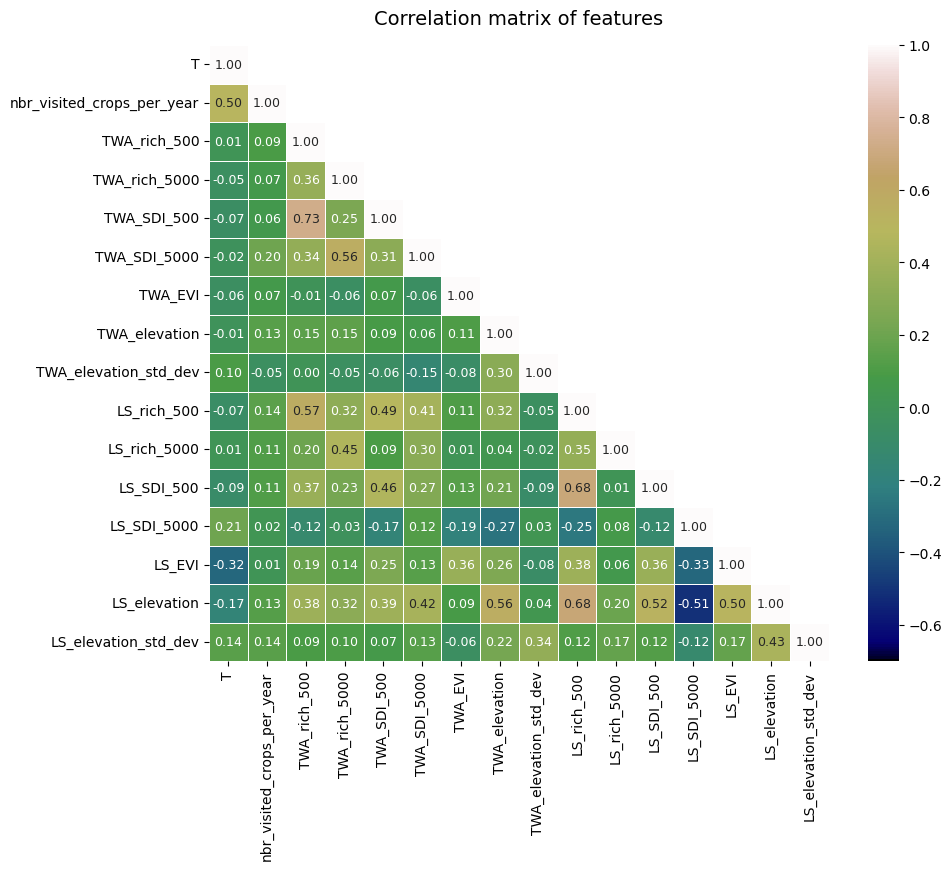

In [ ]:

# creating the corr_matrix
corr_matrix = corr_df.corr()

# creates mask for the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# plot size
plt.figure(figsize=(10, 8))

# plot the corr matrix with sns heatmap
sns.heatmap(corr_matrix, annot=True, cmap='gist_earth', fmt=".2f", linewidths=0.5, mask=mask, annot_kws={"size": 9}, vmin=-.7,vmax=1)

# A
plt.title('Correlation matrix of features', fontsize=14, pad=15)
# plt.tight_layout()

# Save plot
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


Some features are somewhat correlated. Let's visualize the explained variance in 'T' by using a PCA

## Exploration Principal Component Analysis (PCA)

In [ ]:
# PCA with ALL independent features
target = df['T'].to_numpy()
PCA_X = corr_df.drop(columns={'T'})

X_st =  StandardScaler().fit_transform(PCA_X)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_
loadings

# get eigenvalues (variance explained by each PC)
pca_out.explained_variance_


# get biplot
pca_scores = PCA().fit_transform(X_st)

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=PCA_X.columns.values,
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

xs = pca_scores[:, 0]
ys = pca_scores[:, 1]
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

fig, ax = plt.subplots(figsize=(20, 10))

scatter = ax.scatter(xs * scalex, ys * scaley,
                     c=target,
                     cmap='coolwarm_r',
                     alpha=0.3)

texts = []
for i, feature in enumerate(PCA_X.columns):
    ax.arrow(0, 0, pca_out.components_[0, i], pca_out.components_[1, i],
             head_width=0.02, head_length=0.03, color='black', alpha=0.6)
    texts.append(ax.text(pca_out.components_[0, i] * 1.15,
                         pca_out.components_[1, i] * 1.15,
                         feature, fontsize=13, alpha=1))

# adjust_text library allows to prevent label overlap
# adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.4))


ax.set_xlim(-.75, .75)
ax.set_ylim(-.75, .75)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Colony lifespan in days",facecolor='white')
ax.add_artist(legend1)

# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
print("Explained variance ratio of each principal component:")
print(pca_out.explained_variance_ratio_)

print("Cumulative explained variance:")
print(np.cumsum(pca_out.explained_variance_ratio_))

In [ ]:
# variance scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-',color='goldenrod')
plt.grid(True, alpha=0.4)
plt.title('Scree plot of explained variance depending on the number of principal components, \n considering the features used in the RSF model')
plt.xlabel('Number of principal components')
plt.ylabel('Ratio of explained variance')
# plt.savefig(r'path.png',dpi=300,bbox_inches='tight')
plt.show()

# Main analysis section

## Cox time-varying (CTV) model

To run a time-varying survival model, you need to keep all reports. This is why we created df2 before creating df, which has only one report per hive

### Preparing the CTV dataset

Such models typically requires two additional variables: <br> 
* The start and end time specific to each report 
* and event column specific to each report

In [ ]:
# uses df2, a copy() of df which keeps all reports
df2.columns

In [ ]:
# creates an alternate E column. This one is specific to each report (E2) and not to each hive (E)!
df2.loc[:,'E2'] = abs(df2['is_alive'] - 1)

In [ ]:
# Creates the end time column based on the hive_age and the time_interval
df2.loc[:,'end_time'] = df2['hive_age'] + df2['time_interval']

In [ ]:
event_col='E2'
start_col='hive_age'
stop_col='end_time'

In [ ]:
# fix to avoid start col and end col having the same value (same day reports)
df2.loc[:,'end_time'] = df2['end_time'] + 1

### Fitting the model

In [ ]:
# Cox time varying model
ctv = CoxTimeVaryingFitter()

In [ ]:
# Model with Year and operationID grouping variables (to account for beekeeping management practices and yearly weather)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev',
        strata=['year','operationID']
        )

ctv.print_summary(3, model="Year and operationID grouping")

In [ ]:
# Another model with 'maj_crop_500 grouping variables (to neglect the effect of the crop type!)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev', 
        strata=['maj_crop_500']
        )

ctv.print_summary(3, model="maj_crop_500 grouping")

EVI has a considerable effect. Considering it is scaled from 0 to 1, let's rescale to range so that the effect is in 10% steps.

In [ ]:
# rescaling EVI on a 0 to 10 range
df2['EVI'] = df2['EVI'] * 10

In [ ]:
# Including all three grouping features (crop type, management practices, and yearly weather conditions)
ctv.fit(df2,
        id_col='hiveID',
        event_col='E2',
        start_col='hive_age',
        stop_col='end_time', 
        formula='EVI*rich_1000 + SDI_500 + elevation + elevation_std_dev', 
        strata=['maj_crop_500','operationID','year']
        )

ctv.print_summary(3, model="Final model")

<lifelines.CoxTimeVaryingFitter: fitted with 303951 periods, 79032 subjects, 7932 events>
         event col = 'E2'
            strata = ['maj_crop_500', 'operationID', 'year']
number of subjects = 79032
 number of periods = 303951
  number of events = 7932
partial log-likelihood = -38585.972
  time fit was run = 2024-09-20 10:36:06 UTC
             model = Final model

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
EVI               -1.593     0.203     0.046          -1.683          -1.504               0.186               0.222
rich_1000         -0.262     0.770     0.015          -0.292          -0.232               0.747               0.793
SDI_500           -1.222     0.295     0.053          -1.325          -1.118               0.266               0.327
elevation          0.004     1.004     0.000           0.004           0.005               1.004               1.005
elevation_std_dev -0.024     0.976     0.005          -0.033          -0.015               0.967               0.985
EVI:rich_1000      0.105     1.111     0.004           0.098           0.112               1.103               1.119

                   cmp to       z       p  -log2(p)
covariate                                          
EVI                 0.000 -34.850 <0.0005   881.551
rich_1000           0.000 -17.117 <0.0005   215.777
SDI_500             0.000 -23.126 <0.0005   390.644
elevation           0.000  11.676 <0.0005   102.219
elevation_std_dev   0.000  -5.210 <0.0005    22.340
EVI:rich_1000       0.000  28.241 <0.0005   580.456
---
Partial AIC = 77183.945
log-likelihood ratio test = 3060.080 on 6 df
-log2(p) of ll-ratio test = inf

In [ ]:
# Calculate C-index from the partial hazards
partial_hazards = ctv.predict_partial_hazard(df2)

c_index = concordance_index(df2[stop_col], -partial_hazards, df2[event_col])

c_index

In [ ]:
surv = Surv.from_dataframe(event_col, stop_col, df2)

times = np.arange(3, 1075, 5)
cox_auc, cox_mean_auc = cumulative_dynamic_auc(surv, surv, partial_hazards, times)

### CTV model outputs

We can plot the CTV model time-dependant AUC

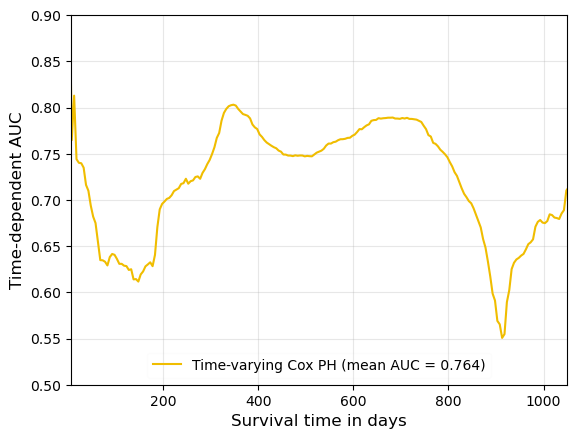

In [ ]:
# Choice of colors for the plot line
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D','#f0bd00']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, cox_auc, "-", label=f"Time-varying Cox PH (mean AUC = {cox_mean_auc:.3f})", color=colors[6]) #  choose the color by index

# plot parameters
plt.xlabel("Survival time in days", fontsize=12)  
plt.ylabel("Time-dependent AUC", fontsize=12)
plt.xlim(7, 1050)
plt.ylim(0.5, 0.9)
plt.legend(loc="lower center", fontsize=10,framealpha=0.05) 
plt.grid(alpha=0.3)

#save the fig
# plt.savefig(r'path',dpi=300,bbox_inches='tight')


plt.show()

We can also visualize the coefs of the features

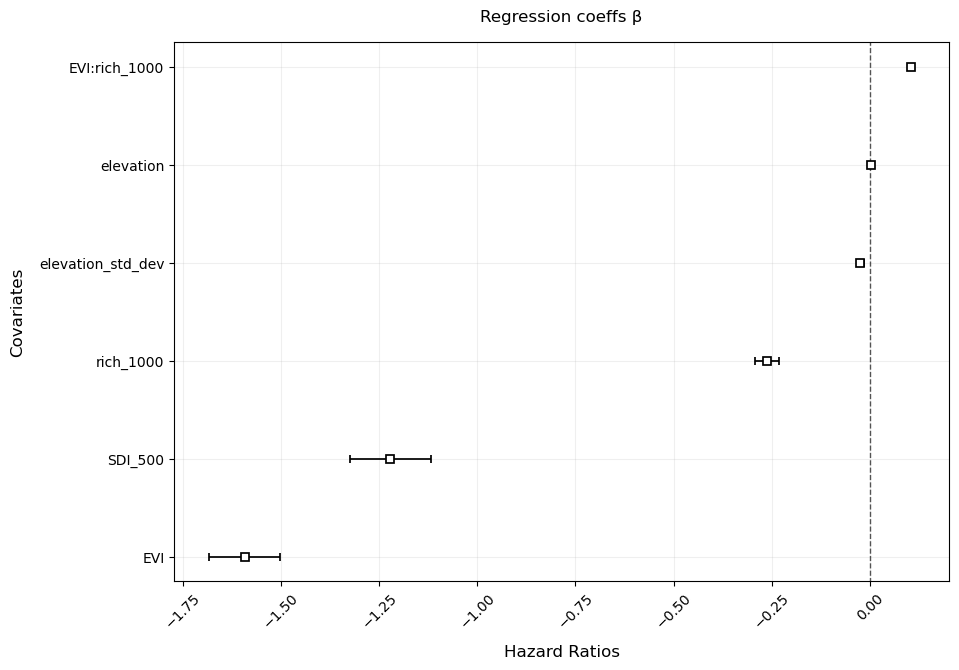

In [ ]:
## Plot the Regression coeff β
fig_verify = plt.figure(figsize=(10,7))
ax = ctv.plot()
plt.title("Regression coeffs β",pad=15)
ax.set_xlabel("Hazard Ratios", fontsize=12,labelpad=10)
ax.set_ylabel("Covariates", fontsize=12,labelpad=10)
plt.grid(True,alpha=0.2)

# Rotate labels for better readability
plt.xticks(rotation=45)

plt.show()

In [ ]:
effect_cox = ctv.summary

# reorder indexes
effect_cox = effect_cox.reindex(['EVI:rich_1000','EVI', 'rich_1000', 'SDI_500', 'elevation', 'elevation_std_dev',
       ])

# rename for plotting
effect_cox.rename(index={'EVI':'Enhanced vegetation index (EVI)',
    'rich_1000':'Richness of land cover or crop types in a 1 km radius',
    'SDI_500':'Landscape diversity (SDI) in a 500 m radius',
    'elevation':'Elevation in meters above mean sea level',
    'elevation_std_dev':'Standard deviation of elevation in meters in a 500 m radius',
    'EVI:rich_1000':'Interaction effect: EVI and richness of crop types in a 1 km radius'},inplace=True)
effect_cox['coef']

In [ ]:
# export model summary
effect_cox.to_csv(r'path.csv')

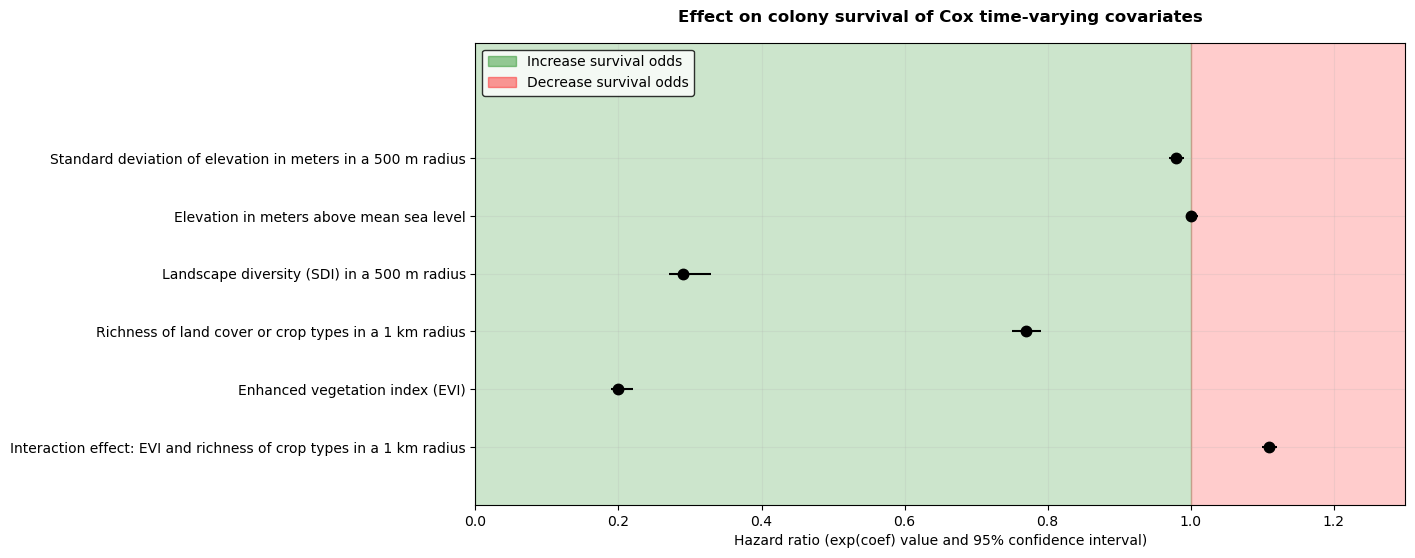

In [ ]:
ce = np.round(np.exp(ctv.confidence_intervals_),2).reset_index()
c = np.round(ctv.hazard_ratios_,2).reset_index()

x = effect_cox.index.values ### covariates
y = effect_cox['exp(coef)'].values
xerr = np.array(list(zip(abs(effect_cox['exp(coef) lower 95%']-effect_cox['exp(coef)'])
                         ,abs(effect_cox['exp(coef) upper 95%']-effect_cox['exp(coef)'])))).T


fig, ax = plt.subplots(figsize=(12,6))
plt.errorbar(y, x, xerr=xerr, fmt='o',color="black",markersize=7.5)
# plt.ylabel("Features")
plt.title("Effect on colony survival of Cox time-varying covariates", fontweight='heavy',pad=15)
plt.xlim(0,1.3)
plt.xlabel('Hazard ratio (exp(coef) value and 95% confidence interval)')
# plt.vlines(1,0,len(x), color="green",lw=4, ls=":")
ax.add_patch(Rectangle((0, -2), 1, 100, color="green", alpha=0.2))
ax.add_patch(Rectangle((1, -2), 100, 100, color="red", alpha=0.2))
ax.set_ylim(-1, len(x) + 1)

red_patch = mpatches.Patch(color='red',alpha=0.5, label='Decrease survival odds')
green_patch = mpatches.Patch(color='green',alpha=0.4, label='Increase survival odds')

# add a legend
plt.legend(handles=[green_patch,red_patch],facecolor='white',frameon=True,edgecolor='black')

plt.grid(alpha=0.2)

# plt.savefig(r'path',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
## Cumulative Baseline Hazard: Ho(t)
CTV_Baselines = pd.concat([ctv.baseline_cumulative_hazard_,    ## Baseline Cumulative Hazard function: Ho(t)
                           ], axis=1).reset_index()

CTV_Baselines.columns = ['Last_cycle',
                         'Ho',
                          ]

print(" \n CTV_Baselines = \n", CTV_Baselines)

## Scatterplots

In [ ]:
df.columns

### E=0 vs E=1 at last visited locations

The goal here is two compare the landscape for two groups: 
1. Colonies that have been last reported alive (Event E = 0)
2. Colonies that have been last reported dead (Event E = 1)

Here, we ask: "are locations which have *caused colony failure* different that those which *keep colonies alive*?"

In [ ]:
# Create two subsets of df based on the event
df_e1 = df[df['E'] == 1]
df_e0 = df[df['E'] == 0]

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\429508267.py:25: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\429508267.py:26: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\429508267.py:25: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgre

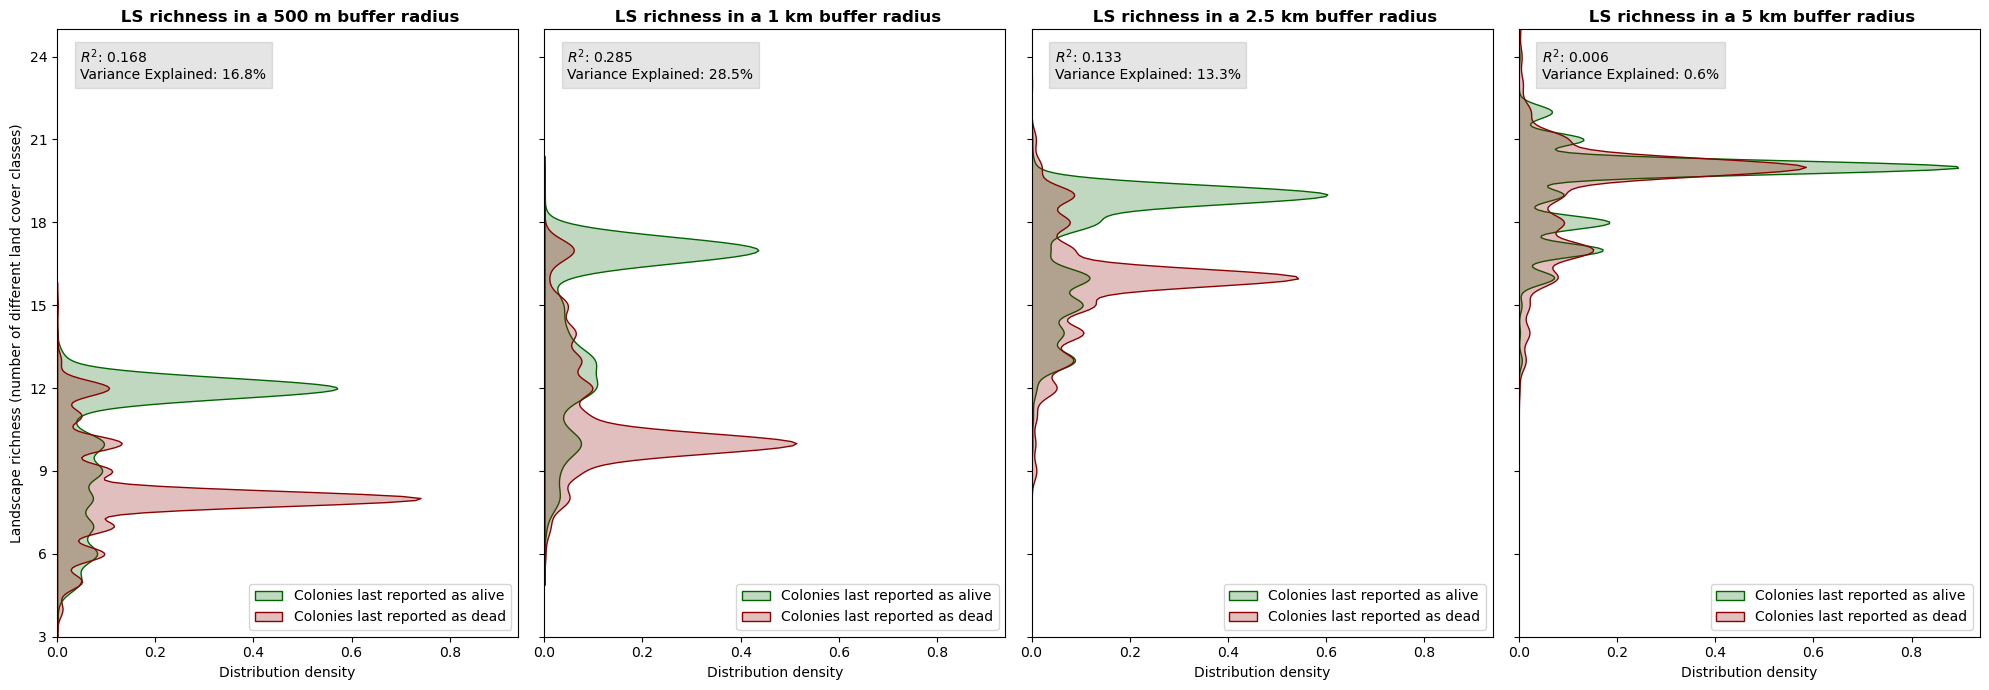

In [ ]:
# List of columns to plot
columns = ['LS_rich_500', 'LS_rich_1000','LS_rich_2500', 'LS_rich_5000']

# Dictionary for title
radius_dict = {
    'LS_rich_500':'500 m','LS_rich_1000':'1 km','LS_rich_2500':'2.5 km','LS_rich_5000':'5 km'
}

# Create a figure with subplots
n_cols = 4
n_rows = len(columns) // n_cols + int(len(columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(columns):
    # Perform the Mann-Whitney U test
    u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])
    
    # Create the distribution plot with density on x and column on y
    sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
    sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
    
    # Retrieve radius for title
    radius = radius_dict.get(col, col)  
    
    # Add labels and title
    axes[i].set_title(f' LS richness in a {radius} buffer radius', fontsize=12, fontweight='bold', pad=5)
    axes[i].set_xlabel('Distribution density')
    axes[i].set_ylabel('Landscape richness (number of different land cover classes)')
    axes[i].legend(loc='lower right',facecolor='white')
    
    # Compute R^2 and percentage of variance explained with linear regression
    X = df[[col]].values
    y = df['E'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    variance_explained = r2 * 100
    
    # add the r2 test result
    annotation_text = (
    # f'Mann-Whitney test:\n'
    #            f'distributions are different with p <= {u_p_value:.3f}\n'
            f'$R^2$: {r2:.3f}\n'
            f'Variance Explained: {variance_explained:.1f}%')
    axes[i].text(0.05, 0.97, annotation_text, transform=axes[i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))
    
# Set y-axis limits and ticks
    axes[i].set_ylim(max(0, np.floor(3)), np.ceil(25))
    axes[i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure y-ticks are integers

# tight layout
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)


plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\3095839507.py:23: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\3095839507.py:24: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\3095839507.py:23: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='dark

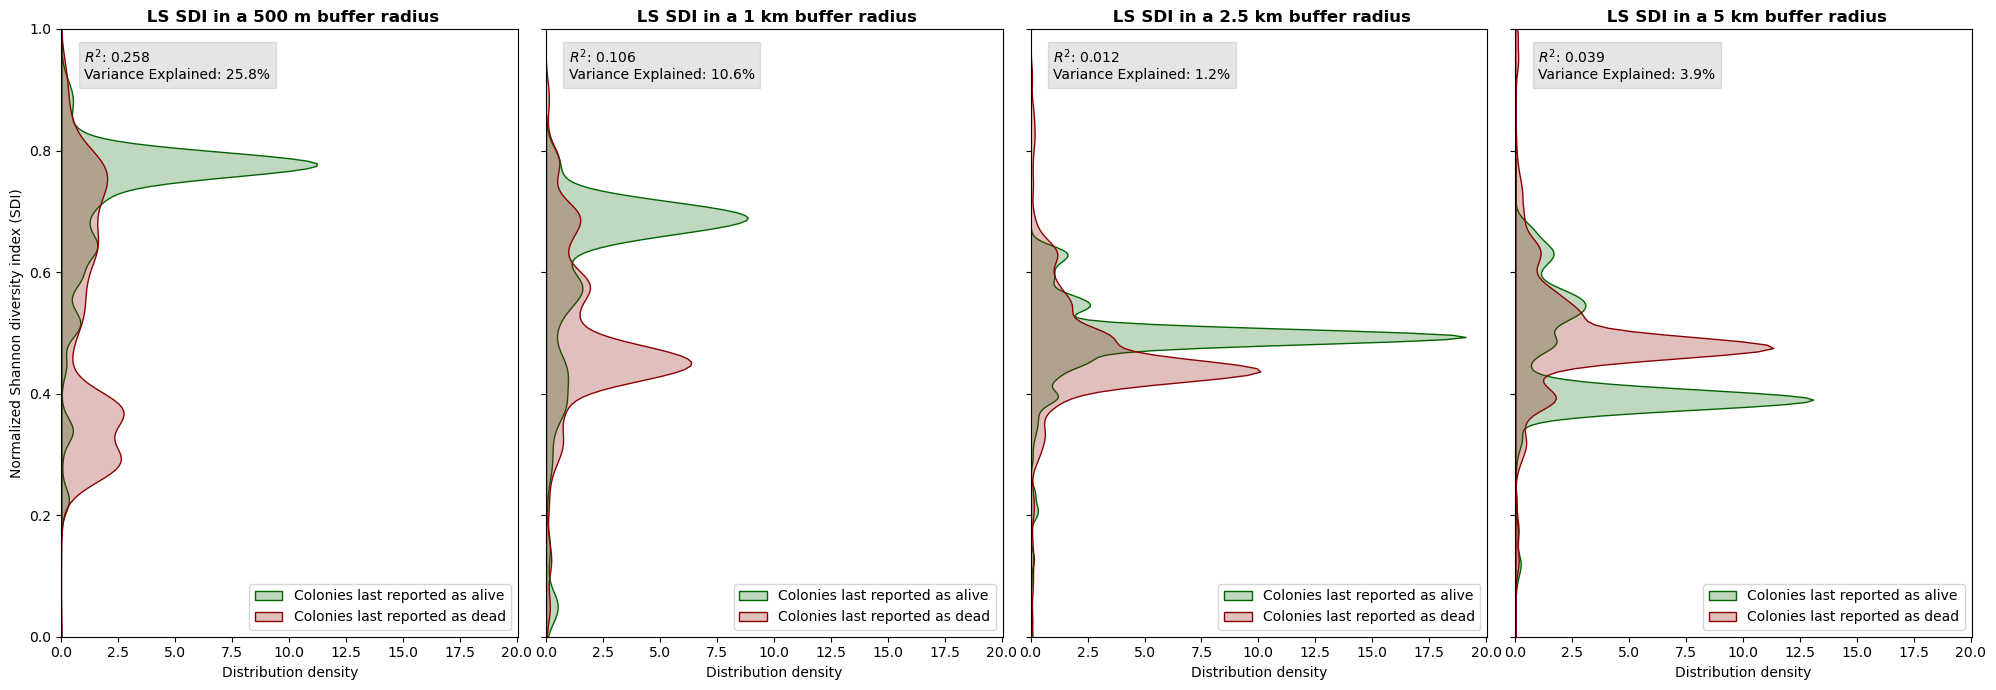

In [ ]:
# List of columns to plot
columns = ['LS_SDI_500','LS_SDI_1000','LS_SDI_2500', 'LS_SDI_5000'] 
 
# Dictionary for title
radius_dict = {
    'LS_SDI_500':'500 m','LS_SDI_1000':'1,000 m','LS_SDI_2500':'2,500 m','LS_SDI_5000':'5,000 m'
}

# Create a figure with subplots
n_cols = 4
n_rows = len(columns) // n_cols + int(len(columns) % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 7 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(columns):
    # Perform the Mann-Whitney U test
    u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])
    
    # Create the distribution plot with density on x and column on y
    sns.kdeplot(df_e0[col], label="Colonies last reported as alive", fill=True, color='darkgreen', vertical=True, ax=axes[i])
    sns.kdeplot(df_e1[col], label="Colonies last reported as dead", fill=True, color='darkred', vertical=True, ax=axes[i])
    
    # Retrieve radius for title
    radius = radius_dict.get(col, col)  

    # Add labels and title
    axes[i].set_title(f' LS SDI in a {radius} buffer radius', fontsize=12, fontweight='bold', pad=5)
    axes[i].set_xlabel('Distribution density')
    axes[i].set_ylabel("Normalized Shannon diversity index (SDI)")
    axes[i].legend(loc='lower right',facecolor='white')
    
    # Compute R^2 and percentage of variance explained with linear regression
    X = df[[col]].values
    y = df['E'].values
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    variance_explained = r2 * 100
    
    # add the r2 test result
    annotation_text = (
        # f'Mann-Whitney test:\n'
        #        f'distributions are different with p <= {u_p_value:.3f}\n'
            f'$R^2$: {r2:.3f}\n'
            f'Variance Explained: {variance_explained:.1f}%')
    axes[i].text(0.05, 0.97, annotation_text, transform=axes[i].transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

plt.ylim(0,1)

# tight layout
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)


plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\3138049320.py:16: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\3138049320.py:17: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


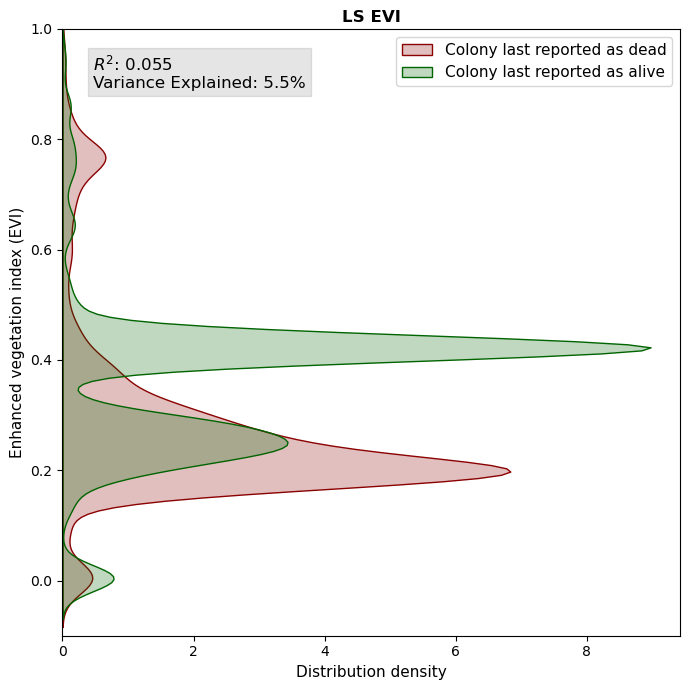

In [ ]:
# Plot column
col = 'LS_EVI'

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'LS EVI', fontsize=12, fontweight='bold', pad=5)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Enhanced vegetation index (EVI)', fontsize=11)
plt.ylim(-.1,1)
plt.legend(fontsize=11, facecolor='white')

# add the r2 test results 
annotation_text = (
    # f'Mann-Whitney test:\n'
    #             #    f'distributions are different with p <= {u_p_value:.3f}\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)

plt.show()


C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\2039837465.py:16: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\2039837465.py:17: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


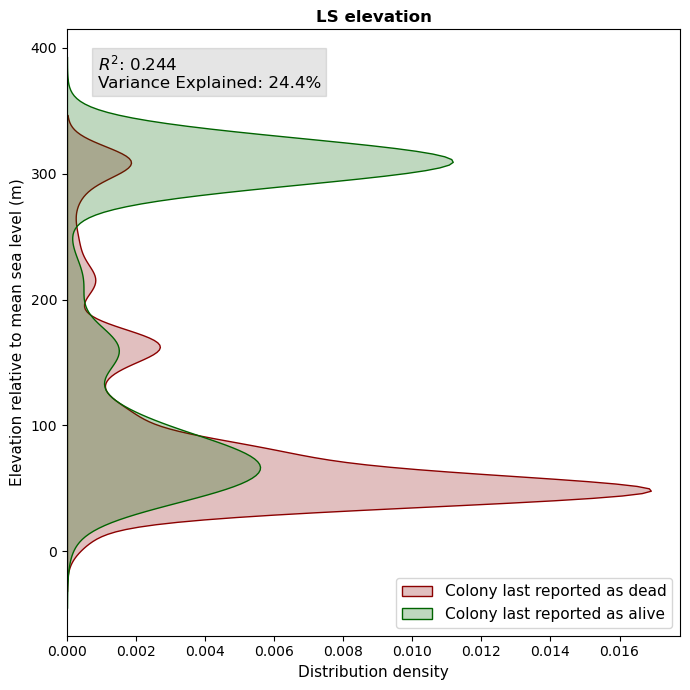

In [ ]:
# Plot column
col = 'LS_elevation'

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'LS elevation', fontweight='bold', pad=5)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Elevation relative to mean sea level (m)', fontsize=11)
# plt.ylim(-2,20)
plt.legend(fontsize=11,loc='lower right',facecolor='white')

# add the r2 test results
annotation_text = (f'Mann-Whitney test:\n'
                #    f'distributions are different with p <= {u_p_value:.3f}\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

# Show the plot
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)

plt.show()

C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\882502209.py:16: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
C:\Users\juvad3723\AppData\Local\Temp\ipykernel_41612\882502209.py:17: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)


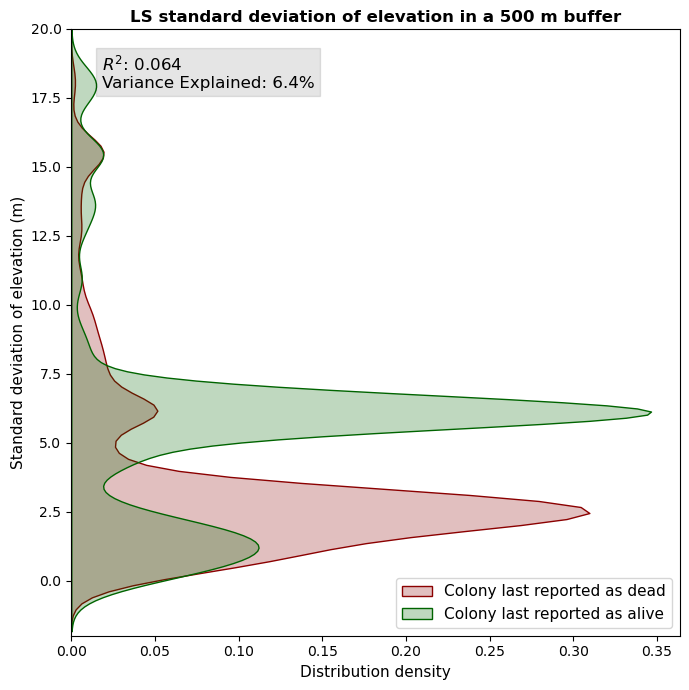

In [ ]:
# Plot column
col = 'LS_elevation_std_dev'

# Perform the Mann-Whitney U test
u_statistic, u_p_value = mannwhitneyu(df_e1[col], df_e0[col])

# Compute R^2 and percentage of variance explained with linear regression
X = df[[col]].values
y = df['E'].values
model = LinearRegression().fit(X, y)
r2 = model.score(X, y)
variance_explained = r2 * 100

# Create the distribution plot
plt.figure(figsize=(7, 7))
sns.kdeplot(df_e1[col], label="Colony last reported as dead", fill=True, color='darkred', vertical=True)
sns.kdeplot(df_e0[col], label="Colony last reported as alive", fill=True, color='darkgreen', vertical=True)

# Add labels and title
plt.title(f'LS standard deviation of elevation in a 500 m buffer', fontsize=12, fontweight='bold', pad=5)
plt.xlabel('Distribution density', fontsize=11)
plt.ylabel('Standard deviation of elevation (m)', fontsize=11)
plt.ylim(-2,20)
plt.legend(fontsize=11,loc='lower right',facecolor='white')

# add the r2 test results
annotation_text = (
    # f'Mann-Whitney test:\n'
    #             #    f'distributions are different with p <= {u_p_value:.3f}\n'
                f'$R^2$: {r2:.3f}\n'
                f'Variance Explained: {variance_explained:.1f}%')
plt.text(0.05, 0.96, annotation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='black', alpha=0.1))

# Show the plot
plt.tight_layout()

# save fig
# plt.savefig(r'path.png',dpi=300)

plt.show()


### Crop maj plots

Local dominant crop. 500 m buffer radius

In [ ]:
# Add synthetic variance to the cranberry group to enhance the following kernel distribution plot 
n = 48

np.random.seed(n) # random seed to allow reproduction
variance_increase = 2.3 # factor

cranberry_mask = df['most_visited_crop_500'] == 'Cranberry'
cranberry_values = df.loc[cranberry_mask, 'T']

# Calculate synthetic variance from initial variance
synthetic_variance = variance_increase * np.var(cranberry_values)

# Generate gaussian synthetic noise around the median
synthetic_noise = np.random.normal(n, np.sqrt(synthetic_variance), size=cranberry_values.shape[0])
synthetic_noise = np.round(synthetic_noise).astype(int)

df.loc[cranberry_mask, 'T'] = df.loc[cranberry_mask, 'T'] + synthetic_noise

df[df['most_visited_crop_500']=='Cranberry']['T'].min() # make sure the minimum T stays positive

In [ ]:
# Calculate the mean of 'days_alive' for each 'most_time_spent_crop'
mean_days_alive = df.groupby('most_visited_crop_500')['T'].mean().sort_values()

mean_days_alive


most_visited_crop_500
Cranberry               90.170455
Cereal crops           220.569817
Maize                  222.579950
Other oilseed crops    224.311111
Canola                 253.142857
Water                  298.666667
Urban                  341.783394
Wetland                342.185185
Coniferous             362.528736
Mixed forest           365.497241
Deciduous              389.573067
Pastures               399.147033
Soybean                406.206797
Blueberry              479.643110
Orchard                535.725240
Name: T, dtype: float64

In [ ]:
# Defines a custom order of crops following the order by mean days alive
custom_order = mean_days_alive.index.to_list()
custom_order.reverse()
custom_order

['Orchard',
 'Blueberry',
 'Soybean',
 'Pastures',
 'Deciduous',
 'Mixed forest',
 'Coniferous',
 'Wetland',
 'Urban',
 'Water',
 'Canola',
 'Other oilseed crops',
 'Maize',
 'Cereal crops',
 'Cranberry']

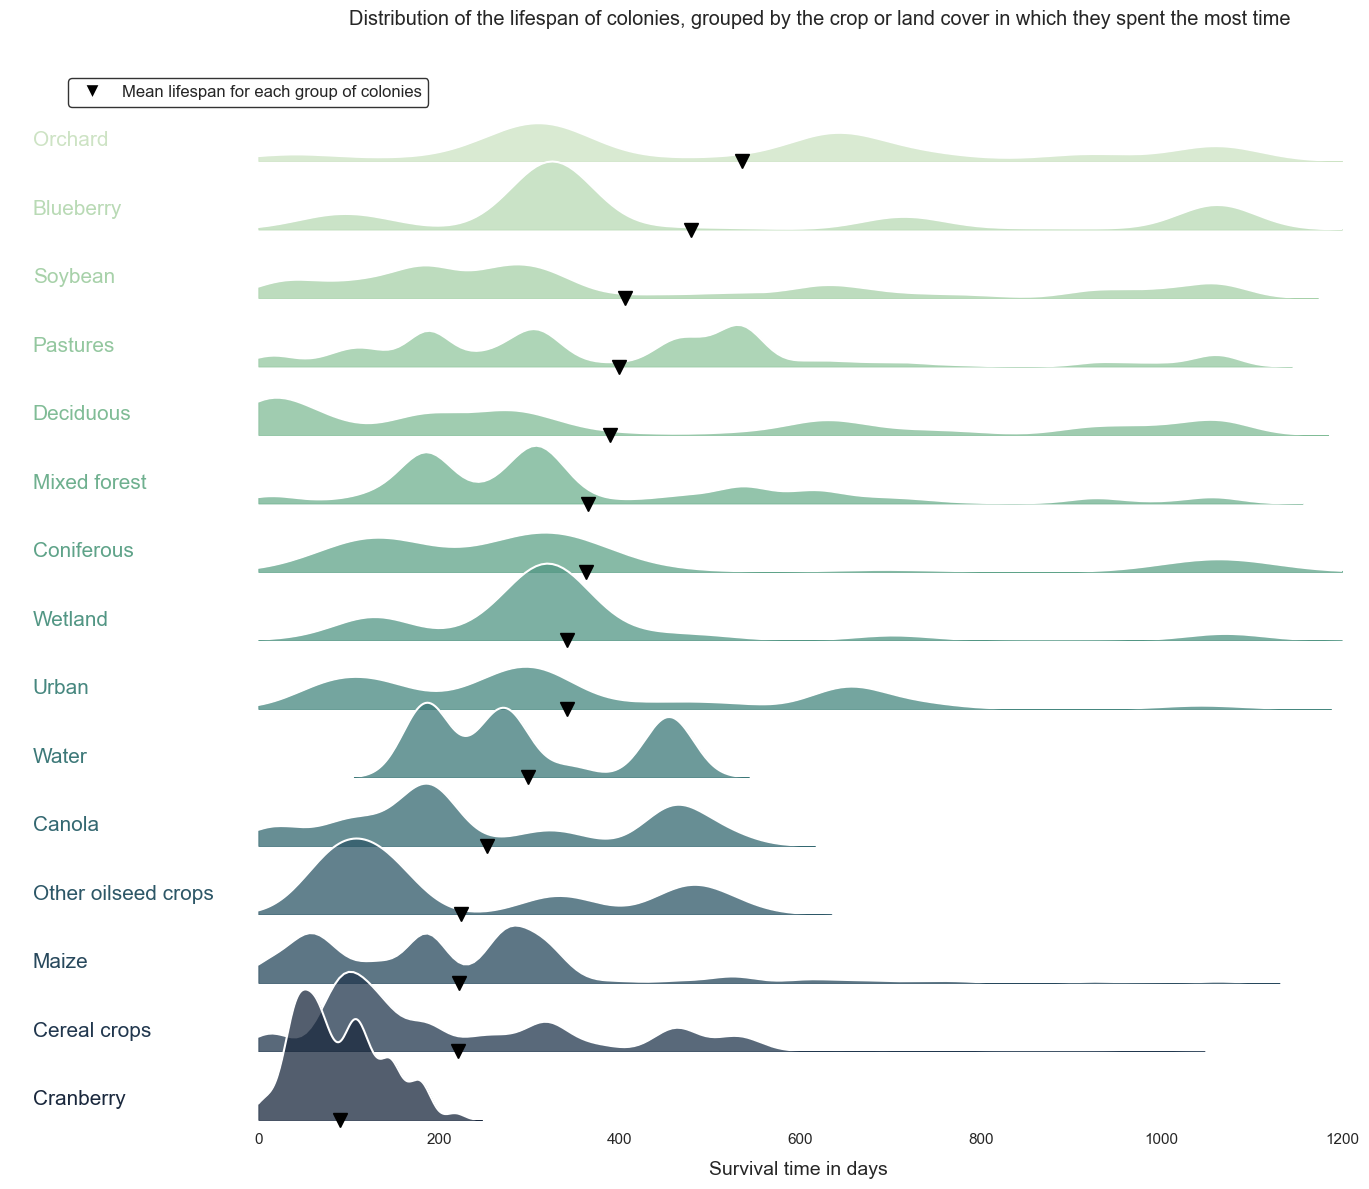

In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

bw = 0.5 # Distribution shape parameter (bandwidth)

# creates a seaborn cubehelix palette for the number of classes
pal = sns.cubehelix_palette(len(custom_order), 3, rot=-0.47, light=0.85)
g = sns.FacetGrid(df, row='most_visited_crop_500', hue='most_visited_crop_500',
                  aspect=18, height=0.8, palette=pal, row_order=custom_order, hue_order=custom_order)

# Seaborn kernel densities estimate plot
g.map(sns.kdeplot, "T", bw_adjust=bw, clip=(0, 1200), fill=True, alpha=.75, linewidth=.5)
g.map(sns.kdeplot, "T", clip=(0, 1200), color="w", lw=1.5, bw_adjust=bw)

# Function to label the axes (crops) and add a marker at the mean
def label_and_marker(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.15, label, color=color, ha="left", va="center", transform=ax.transAxes, fontsize=15)
    mean_value = mean_days_alive[label]
    ax.plot(mean_value, 0, marker="v", markersize=10, color='black', clip_on=False)

# Apply the label and marker function
g.map(label_and_marker, 'T')
g.figure.subplots_adjust(hspace=-0.5)
# xy labels
g.set_xlabels('Survival time in days', fontsize=14, labelpad=10, x=0.585) 
g.set_ylabels('Dominant crop type/land cover')

# Set x-axis limits
g.set(xlim=(-250, 1200))  # negative x lower limit for visualization fix

# Remove x-axis labels below 0
for ax in g.axes.flat:
    ax.set_xticks(ax.get_xticks()[ax.get_xticks() >= 0])
    # ax.margins(x=0.5)

# Fig title
g.figure.suptitle('Distribution of the lifespan of colonies, grouped by the crop or land cover in which they spent the most time')

# Remove axes titles that overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Create custom legend
legend_elements = [Line2D([0], [0], marker='v', color='w', label='Mean lifespan for each group of colonies',
                          markerfacecolor='black', markersize=10, linestyle='None')]

# Add the custom legend to the plot
g.add_legend(handles=legend_elements, title="", loc=(0.05, 0.91), frameon=True, edgecolor='black', facecolor='none', fontsize=12)

# export fig
# plt.savefig(r'path.png',dpi=300)

# Show the plot
plt.show()


In [ ]:
grouped_df = df.groupby('most_visited_crop_500').agg(
    mean_days_alive=pd.NamedAgg(column='T', aggfunc='mean'),
    median_days_alive=pd.NamedAgg(column='T', aggfunc='median'),
    stddev_days_alive=pd.NamedAgg(column='T', aggfunc='std'),
    count=pd.NamedAgg(column='T', aggfunc='size')
).reset_index().round(0)

# Table for each crop group
grouped_df.columns = ['Group', 'Mean', 'Median', 'Std dev', 'Hive count']
grouped_df = grouped_df.sort_values('Mean')

# grouped_df.to_csv(r'path',sep=';')
grouped_df

,Group,Mean,Median,Std dev,Hive count
4,Cranberry,90.0,82.0,49.0,88
2,Cereal crops,221.0,149.0,159.0,709
6,Maize,223.0,188.0,176.0,1207
9,Other oilseed crops,224.0,141.0,162.0,45
1,Canola,253.0,188.0,160.0,91
13,Water,299.0,277.0,109.0,42
12,Urban,342.0,296.0,232.0,277
14,Wetland,342.0,320.0,206.0,81
3,Coniferous,363.0,293.0,305.0,87
7,Mixed forest,365.0,304.0,235.0,1631


In [ ]:
# Generate a descriptive table of each df feature
descriptive_table = df.describe(percentiles=[.5]).T[['mean','50%','std','min','max',]].rename(columns={'50%':'median'})

# export
# descriptive_table.to_csv(r'path.csv',sep=';')

descriptive_table

,mean,median,std,min,max
hiveID,97070.366705,79233.500000,73055.969408,12449.000000,273886.000000
year,2023.076838,2023.000000,0.811744,2021.000000,2024.000000
operationID,105.971743,55.000000,59.384449,55.000000,224.000000
is_alive,0.541054,1.000000,0.498326,0.000000,1.000000
E,0.458946,0.000000,0.498326,0.000000,1.000000
T,377.897800,303.000000,292.063998,1.000000,1076.000000
hive_age,378.382050,303.500000,292.291211,1.000000,1077.000000
LS_rich_500,9.355067,9.000000,2.272337,2.000000,15.000000
LS_rich_1000,12.969137,12.000000,3.143402,6.000000,19.000000
LS_rich_2500,16.612681,16.000000,2.236783,8.000000,23.000000


### Nbr of visited crops vs T

We can also have a look at the distribution of crops based on the number of different crops they visited during the year. <br>
We must create a subset of the dataset to consider only hives which have been reported dead **and** who lived for at least one year including wintering (365 days). <br> <br>
*Otherwise, young hives and rapid mortality make huge bias for the first group (1 crop)*

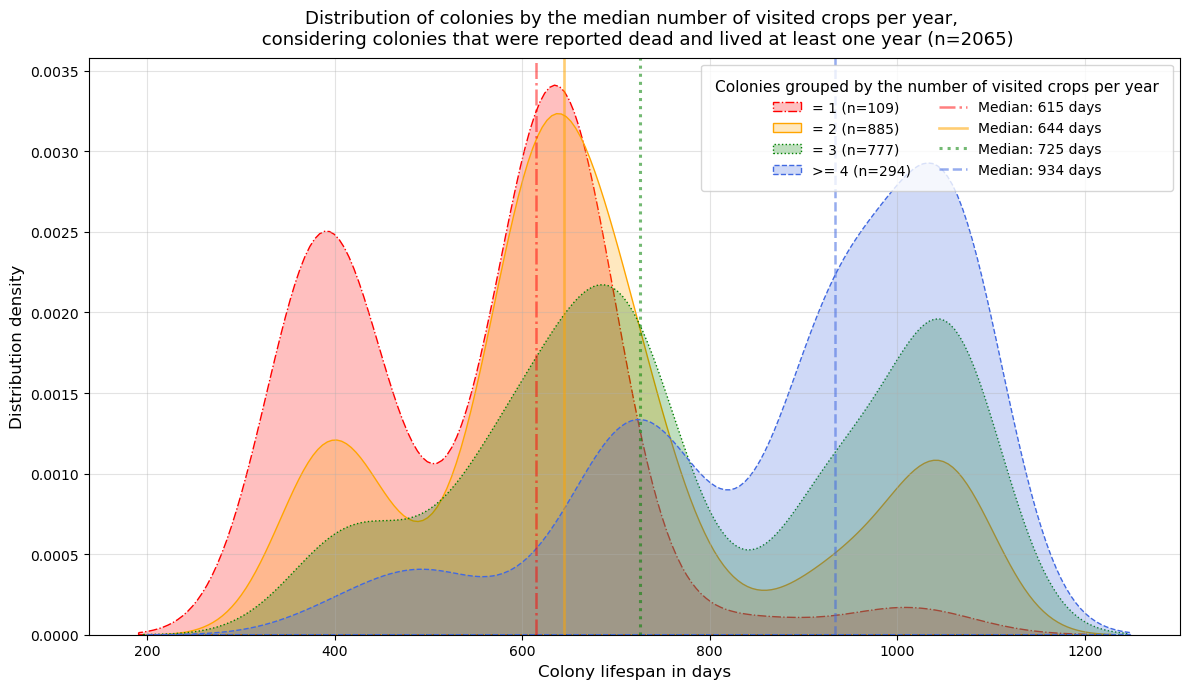

In [ ]:
# Creates a copy of df but only considering colonies who lived at least a year
df_minT = df[df['T'] >= 365]
df_minT = df_minT[df_minT['E'] == 1]

# Plt figure
plt.figure(figsize=(12, 7))

# Define groups
gr1 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 1]['T']
gr2 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 2]['T']
gr3 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) == 3]['T']
gr4 = df_minT[df_minT['nbr_visited_crops_per_year'].astype(int) >= 4]['T']

# KDE Plot for distribution
sns.kdeplot(gr1, label=f'= 1 (n={len(gr1)})', fill=True, color='red', linestyle='-.')
sns.kdeplot(gr2, label=f'= 2 (n={len(gr2)})', fill=True, color='orange', linestyle='-')
sns.kdeplot(gr3, label=f'= 3 (n={len(gr3)})', fill=True, linewidth=1, color='green', linestyle=':')
sns.kdeplot(gr4, label=f'>= 4 (n={len(gr4)})', fill=True, color='royalblue', linestyle='--')

# Add vertical lines for the median of each group
plt.axvline(gr1.median(), color='red', linestyle='-.', linewidth=1.8, label=f'Median: {gr1.median():.0f} days',alpha=.5)
plt.axvline(gr2.median(), color='orange', linestyle='-', linewidth=1.9, label=f'Median: {gr2.median():.0f} days',alpha=.55)
plt.axvline(gr3.median(), color='green', linestyle=':', linewidth=2.2, label=f'Median: {gr3.median():.0f} days',alpha=.55)
plt.axvline(gr4.median(), color='royalblue', linestyle='--', linewidth=1.8, label=f'Median: {gr4.median():.0f} days',alpha=.55)

# Plot settings
plt.title(f'Distribution of colonies by the median number of visited crops per year, \n considering colonies that were reported dead and lived at least one year (n={len(df_minT)})', fontsize=13, pad=10)
plt.xlabel('Colony lifespan in days', fontsize=12)
plt.ylabel('Distribution density', fontsize=12)
plt.legend(title='Colonies grouped by the number of visited crops per year', title_fontsize=11, ncol=2, borderpad=1)
plt.grid(True,alpha=0.5)
plt.tight_layout()

# Export
# plt.savefig(r'path', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
sns.reset_defaults()

## RSF

In the RSF, we will use the TWA features. We can't really use the Last seen (LS) metrics as those only apply in the last location visited by the hive. <br>
Also, we chose to not include features such as 'operationID' and 'year' since the goal is to focus on habitat and foraging landscape metrics.

In [ ]:
df.columns

### Baseline RSF model

We define the columns for a general model

In [ ]:
rsfcol = [
    # 'LS_sdi_500', 'LS_sdi_2500', 'LS_sdi_5000', 'LS_EVI' # see coments above, it would be wrong to use these
    # we let aside the metrics at 1000 and 2500 m to avoid multicollinearity
    'TWA_rich_500','TWA_rich_5000',
    'TWA_SDI_500','TWA_SDI_5000',
    'TWA_EVI','TWA_elevation','TWA_elevation_std_dev',
    'nbr_visited_crops_per_year'
    ]

We split the the data using a 70/30 training/testing ratio

In [ ]:
# RSF model
X = df[rsfcol]
T = df['T'].astype(int)
E = df['E'].astype(int)

# Combine 'T' and 'E' into a structured array for survival analysis
y = Surv.from_arrays(E, T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=E, random_state=1) # E stratify as recommended by scitkit-surv docs

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=100, random_state=1, max_depth=10, min_samples_leaf=1 # 200 trees = 8.5 mins 
                        #   ,max_features='sqrt'
                           )

rsf.fit(X_train,y_train)
rsf.score(X_test,y_test)

0.8258152897627086

The accuracy is good, but the model is not optimal in assessing feature importance because of high collinearity between richness and SDI features. Perhaps we can use PCA again to reduce dimensionality between these two groups of features

### RSF + PCA

Using a PCA, we can now add the metrics at all computed scales (500-1000-2500-5000 m)

#### Diversity PCA

In [ ]:
# Diversity columns to reduce dimensionality
pca_cols = ['TWA_SDI_500', 'TWA_SDI_1000', 'TWA_SDI_2500', 'TWA_SDI_5000', 
                     'TWA_rich_500', 'TWA_rich_1000', 'TWA_rich_2500', 'TWA_rich_5000']

We can load and plot this two way PCA

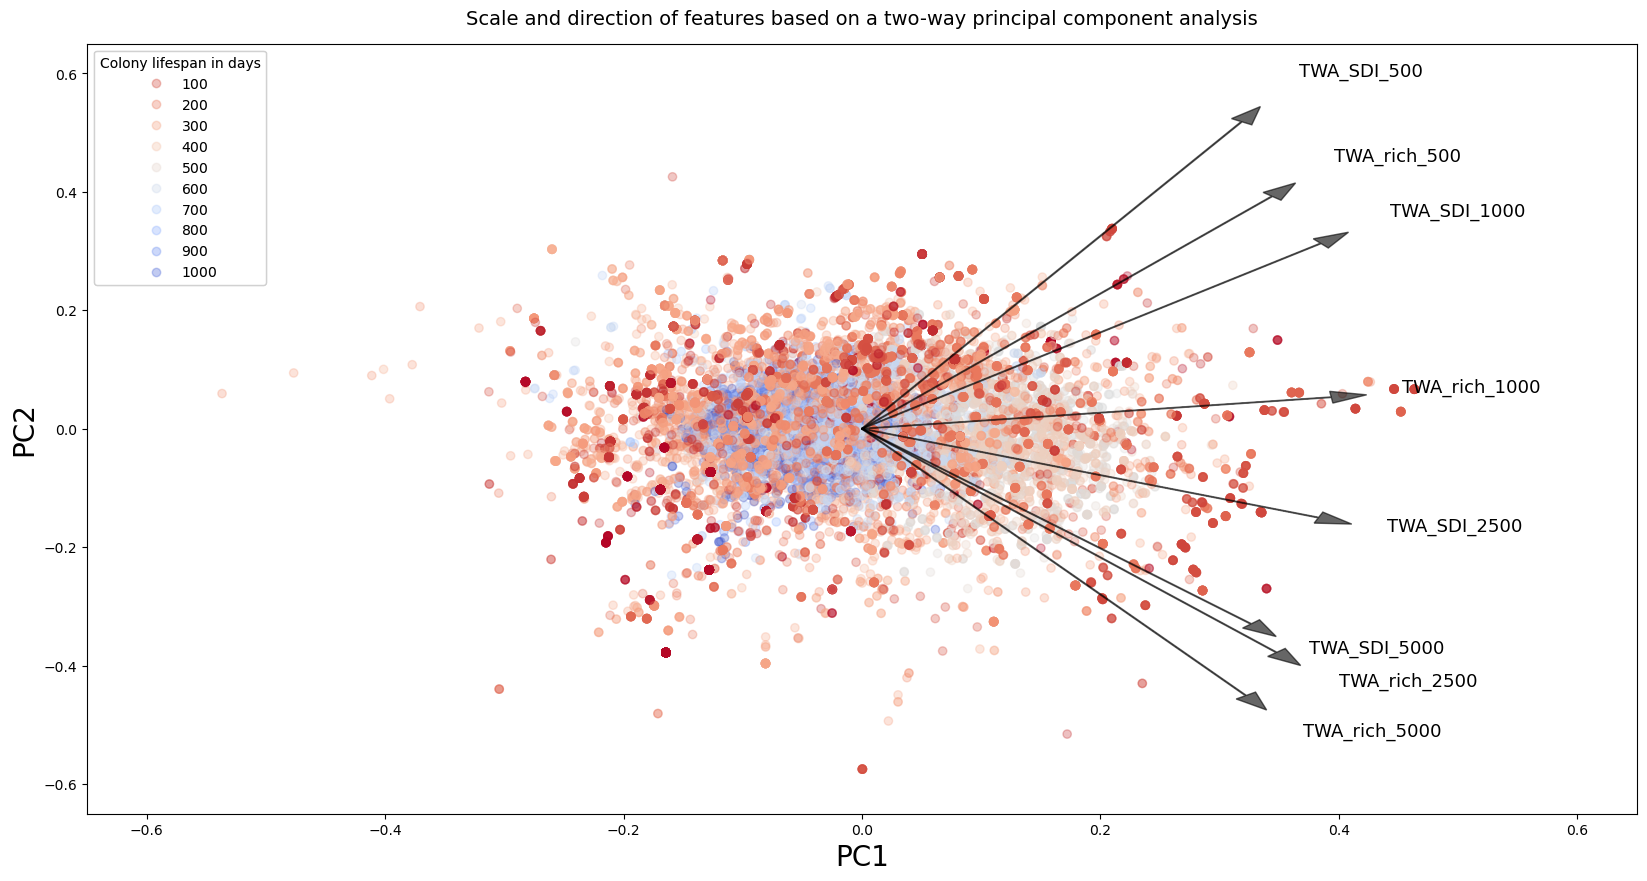

In [ ]:
# PCA
target = df['T'].to_numpy()
PCA_X = df[pca_cols]

X_st =  StandardScaler().fit_transform(PCA_X)
pca_out = PCA().fit(X_st)

# component loadings
loadings = pca_out.components_

# get eigenvalues (variance explained by each PC)
pca_out.explained_variance_


# get biplot
pca_scores = PCA().fit_transform(X_st)

cluster.biplot(cscore=pca_scores, loadings=loadings, labels=PCA_X.columns.values,
               var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

xs = pca_scores[:, 0]
ys = pca_scores[:, 1]
scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

fig, ax = plt.subplots(figsize=(20, 10))

scatter = ax.scatter(xs * scalex, ys * scaley,
                     c=target,
                     cmap='coolwarm_r',
                     alpha=0.3)

texts = []
for i, feature in enumerate(PCA_X.columns):
    ax.arrow(0, 0, pca_out.components_[0, i], pca_out.components_[1, i],
             head_width=0.02, head_length=0.03, color='black', alpha=0.6)
    texts.append(ax.text(pca_out.components_[0, i] * 1.15,
                         pca_out.components_[1, i] * 1.15,
                         feature, fontsize=13, alpha=1))

# adjust_text library allows to prevent label overlap
# adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", color='black', lw=0.4))


ax.set_xlim(-.65, .65)
ax.set_ylim(-.65, .65)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
plt.title('Scale and direction of features based on a two-way principal component analysis', pad=14,fontsize=14)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Colony lifespan in days",facecolor='white')
ax.add_artist(legend1)

# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# explained variance ratio
explained_variance_ratio = pca_out.explained_variance_ratio_

print("Explained variance ratio of each principal component:")
print(pca_out.explained_variance_ratio_)

# cumulative explained variance
print("Cumulative explained variance:")
print(np.cumsum(pca_out.explained_variance_ratio_))

Explained variance ratio of each principal component:
[0.61699233 0.16432055 0.0949706  0.03867104 0.03335582 0.02282998
 0.01703825 0.01182144]
Cumulative explained variance:
[0.61699233 0.78131288 0.87628348 0.91495452 0.94831033 0.97114031
 0.98817856 1.        ]


We can use the scree plot and the Kaiser criterion to decide on the number of components to keep

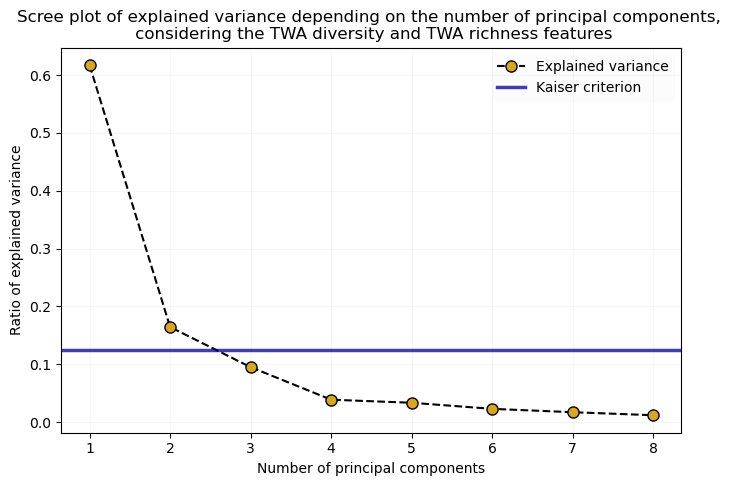

In [ ]:
# scree plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o',markersize=8, markerfacecolor='goldenrod', linestyle='--', color='black', label='Explained variance')

# Kaiser criterion line : eigenvalue=1
kaiser = 1 / len(explained_variance_ratio)
plt.axhline(y=kaiser, color='darkblue', linestyle='-',lw=2.5, label='Kaiser criterion ',alpha=0.75)

plt.grid(True, alpha=0.1)
plt.title('Scree plot of explained variance depending on the number of principal components, \n considering the TWA diversity and TWA richness features')
plt.xlabel('Number of principal components')
plt.ylabel('Ratio of explained variance')
plt.legend(facecolor='grey',framealpha=0.025)

# Save the figure
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Standard scaler on the cols
scaled_data = StandardScaler().fit_transform(df[pca_cols])

# Apply PCA
pca = PCA(n_components=2) # 2 components based on the Kaiser criterion
pca_result = pca.fit_transform(scaled_data)

# Joins the results of the two principal PCs to the df
df['Div_PCA_1'] = pca_result[:, 0]
df['Div_PCA_2'] = pca_result[:, 1]


In [ ]:
# New list of rsf columns
rsf_cols = ['TWA_EVI','nbr_visited_crops_per_year','TWA_elevation','TWA_elevation_std_dev','Div_PCA_1','Div_PCA_2']

#### Training final RSF model

We ran a grid search for hyperparameters tuning

In [ ]:
# grid search hyperparameters
gr_space = {
    'max_depth': [5,7,10,12],
    'n_estimators': [100, 300, 500],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Rsf model splits
X = df[rsf_cols]
T = df['T'].astype(int)
E = df['E'].astype(int)

# Combine 'Years' and 'E' into a structured array for survival analysis
y = Surv.from_arrays(E, T)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=E, random_state=1)

In [ ]:
rsf = RandomSurvivalForest(random_state=1)

# grid search on training dataset with 3 cross validation folds
grid = GridSearchCV(rsf, gr_space, cv = 3,verbose=3)
model_grid = grid.fit(X_train, y_train)

model_grid.best_params_

In [ ]:
# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(n_estimators=500, random_state=1, max_depth=10, min_samples_leaf=2 
                        #   ,max_features='sqrt'
                           )

# Fit the model on training split
rsf.fit(X_train,y_train)

# Predict on testing split and get C-index
rsf.score(X_test,y_test)

### RSF results

#### Survival probability curves

In [ ]:
## creating a median grouped sample
## Creating a sample of the X split but adding the grouping column
median_sample = X.join(df[['most_visited_crop_500','T']]).groupby('most_visited_crop_500').median(numeric_only=True).reset_index()

median_sample.index = median_sample['most_visited_crop_500']

# Delete the column from its original position
del median_sample['most_visited_crop_500']

median_sample = median_sample.reindex(custom_order)

median_sample

In [ ]:
# Export median_sample
# median_sample.to_csv(r'path.csv',sep=';')

#Drop 'T' for next model training
median_sample = median_sample.drop(columns={'T'})

In [ ]:
# define a list of custom colors following the order above
custom_colors = [
    '#d40000',  # Orchard
    '#4682B4',  # Blueberry
    '#FF6347',  # Soybean 
    '#d1e903',  # Pastures 
    '#3dc502',  # Deciduous
    '#6f3900',  # Mixed Forest 
    '#006400',  # Coniferous 
    '#03ac90',  # Wetland turquoise
    '#7a23a9',  # Urban 
    '#6bd7fa',  # Water 
    '#f2f201',  # Canola
    '#db00de',  # Oilseed crops
    '#e69d00',  # Maize
    '#c1a47f',  # Cereal crops
    '#DB7093'   # Cranberry 
]

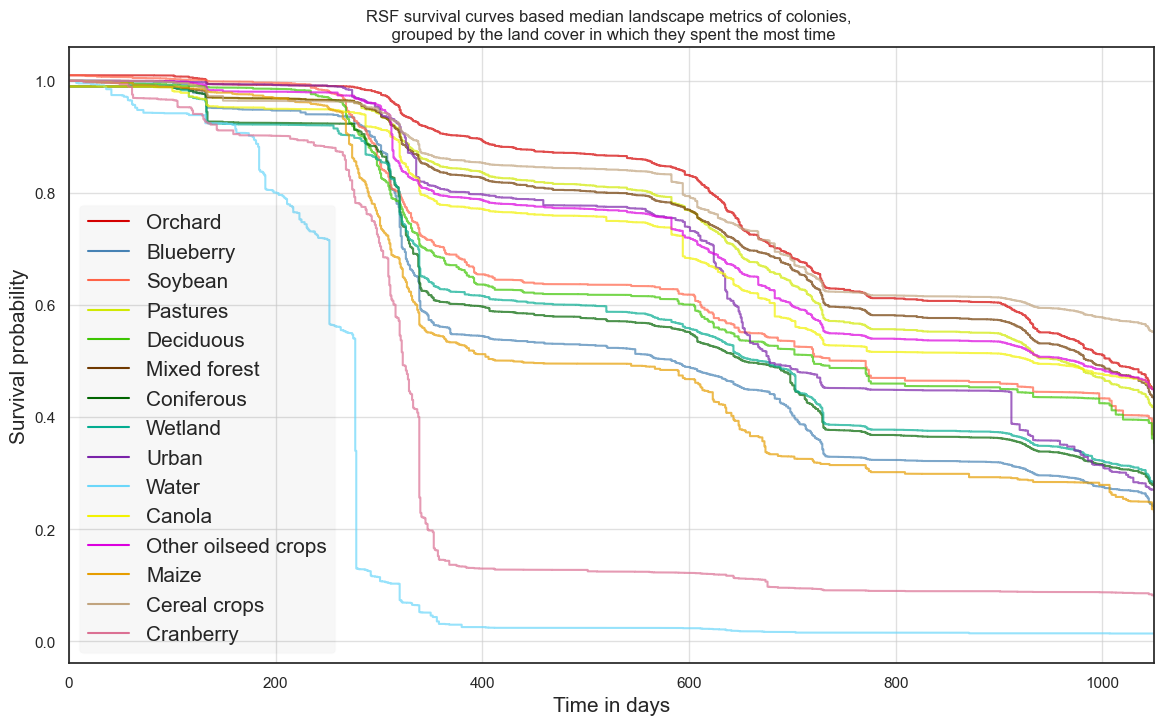

In [ ]:
# predict the survival functions following the sk-surv guidelines
surv = rsf.predict_survival_function(median_sample, return_array=True)

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot survival functions for each crop group with the assigned colors
for i, (s, color) in enumerate(zip(surv, custom_colors)):
    
    # Improving readability by adding a small offset to overlapping functions
    if median_sample.iloc[i].name == 'Canola':
        s = s - 0.01
    if median_sample.iloc[i].name == 'Coniferous':
        s = s - 0.01 
    if median_sample.iloc[i].name == 'Orchard':
        s = s + 0.01
    if median_sample.iloc[i].name == 'Mixed forest':
        s = s - 0.01
    if median_sample.iloc[i].name == 'Soybean':
        s = s + 0.01
    
    # plot the curves
    plt.step(rsf.unique_times_, s, where="post", label=median_sample.iloc[i].name, color=color, alpha=0.7)

# Figure params
plt.ylabel("Survival probability", fontsize=15)
plt.xlabel("Time in days", fontsize=15)
plt.title('RSF survival curves based median landscape metrics of colonies, \n grouped by the land cover in which they spent the most time')
plt.xlim(0, 1050)
legend = plt.legend(loc='best',frameon=True,facecolor='black',framealpha=0.03,prop={'size': 15})
plt.grid(True, alpha=0.6)
for handle in legend.get_lines():
    handle.set_alpha(1.0)  # Set the alpha for legend symbols to be fully opaque

# Export plot
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()


Also possible but perhaps less interesting is to repeat this but considering the major crop in a 2500m buffer instead of local crop

In [ ]:
# Calculate the mean of 'days_alive' for each 'most_time_spent_crop'
mean_days_alive = df.groupby('most_visited_crop_2500')['T'].mean().sort_values()

mean_days_alive


In [ ]:
# Defines a custom order of crops following the order by mean days alive
custom_order = mean_days_alive.index.to_list()
custom_order.reverse()
custom_order

In [ ]:
## creating a median grouped sample
## Creating a sample of the X split but adding the grouping column
median_sample = X.join(df['most_visited_crop_2500']).groupby('most_visited_crop_2500').median(numeric_only=True).reset_index()

median_sample.index = median_sample['most_visited_crop_2500']

# Delete the column from its original position
del median_sample['most_visited_crop_2500']

median_sample = median_sample.reindex(custom_order)

median_sample

In [ ]:
# 2500 m buffer color list
custom_colors = [
    '#d40000',  # Orchard 
    '#4682B4',  # Blueberry 
    '#006400',  # Coniferous 
    '#3dc502',  # Deciduous 
    '#FF6347',  # Soybean 
    '#7a23a9',  # Urban 
    '#6f3900',  # Mixed Forest
    '#d1e903',  # Pastures 
    '#c1a47f',  # Cereal crops
    '#03ac90',  # Wetland 
    '#e69d00',  # Maize 
    '#DB7093'   # Cranberry 
]

In [ ]:
# predict the survival functions following the sk-surv guidelines
surv = rsf.predict_survival_function(median_sample, return_array=True)

# Set the figure size
plt.figure(figsize=(14, 8))

# Plot survival functions for each crop group with the assigned colors
for i, (s, color) in enumerate(zip(surv, custom_colors)):
    
    # Improving readability by adding a small offset to overlapping functions
    # if median_sample.iloc[i].name == 'Canola':
    #     s = s - 0.01
    # if median_sample.iloc[i].name == 'Coniferous':
    #     s = s - 0.01 
    if median_sample.iloc[i].name == 'Orchard':
        s = s + 0.01
    if median_sample.iloc[i].name == 'Mixed forest':
        s = s - 0.01
    # if median_sample.iloc[i].name == 'Soybean':
    #     s = s + 0.01

    plt.step(rsf.unique_times_, s, where="post", label=median_sample.iloc[i].name, color=color, alpha=0.7)

# Customize the plot
plt.ylabel("Survival probability", fontsize=15)
plt.xlabel("Time in days", fontsize=15)
plt.title('RSF survival curves based median landscape metrics of colonies, \n grouped by the land cover in which they spent the most time (2500 m)')
plt.xlim(0, 1050)
legend = plt.legend(loc='best',frameon=True,facecolor='black',framealpha=0.03,prop={'size': 15})
plt.grid(True, alpha=0.6)
for handle in legend.get_lines():
    handle.set_alpha(1.0)  # Set the alpha for legend symbols to be fully opaque

# Save the figure (optional)
# plt.savefig(r'path.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [ ]:
grouped_df = df.groupby('most_visited_crop_2500').agg(
    mean_days_alive=pd.NamedAgg(column='T', aggfunc='mean'),
    median_days_alive=pd.NamedAgg(column='T', aggfunc='median'),
    stddev_days_alive=pd.NamedAgg(column='T', aggfunc='std'),
    count=pd.NamedAgg(column='T', aggfunc='size')
).reset_index().round(0)

# Table for each crop group
grouped_df.columns = ['Group', 'Mean', 'Median', 'Std dev', 'Hive count']
grouped_df = grouped_df.sort_values('Mean')

# grouped_df.to_csv(r'path.csv',sep=';')
grouped_df

#### AUC

In [ ]:
# Concordance (C-index)
rsf.score(X_test, y_test)

In [ ]:
#times = times #we use the same times as defined in the cox model.

# Compute predicted survival probabilities using the RSF model
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(times) for chf in rsf_chf_funcs])

# followign the sk-surv guidelines
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, times)

In [ ]:
# Choice of colors for the plot line
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, rsf_auc, "-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})", color=colors[1]) #  choose the color by index

# Plot parameters
plt.xlabel("Survival time in days", fontsize=12)  
plt.ylabel("Time-dependent AUC", fontsize=12)
plt.xlim(5, 1050)
plt.legend(loc="lower center", fontsize=10,framealpha=0.05) 
plt.grid(alpha=0.3)

#save the fig
# plt.savefig(r'path.png',dpi=300,bbox_inches='tight')


plt.show()

We can then compare this predicted AUC of the RSF with the Cox PH model

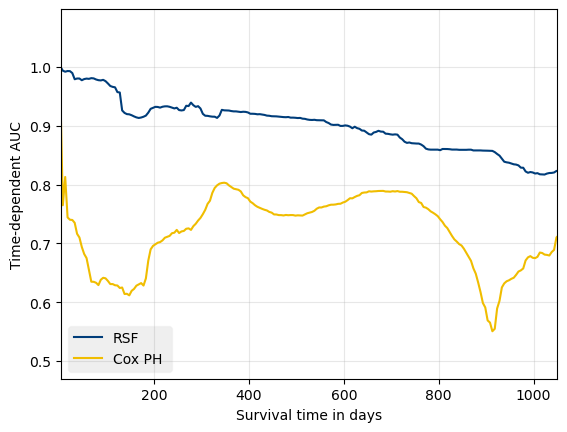

In [ ]:
# Choice of colors for the plot lines
colors = ['#05009B', '#003D7A', '#2ca02c','#59007A','#D12900','#79004D','#f0bd00']  

# Plot the AUC curve and label the mean AUC
plt.plot(times, rsf_auc, "-", label=f"RSF", color=colors[1]) #  choose the color by index

plt.plot(times, cox_auc, "-", label=f"Cox PH ", color=colors[6]) #  choose the color by index

# plot parameters
plt.xlabel("Survival time in days", fontsize=10)  
plt.ylabel("Time-dependent AUC", fontsize=10)
plt.xlim(5, 1050)
plt.ylim(0.47,1.098)
plt.legend(loc="lower left", fontsize=10,framealpha=0.12,facecolor='grey') 
plt.grid(alpha=0.3)

#save the fig
# plt.savefig(r'path.png',dpi=300,bbox_inches='tight')

plt.show()

#### Feature importance

Estimating feature importance of full RSF model

In [ ]:
# Estimating feature importance using 4 fold permutation (using scikit-learn permutation importance)
result = permutation_importance(rsf, X_test, y_test, n_repeats=4, random_state=1)

In [ ]:
var_imp = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

# round decimals
var_imp = var_imp.round(4)

var_imp

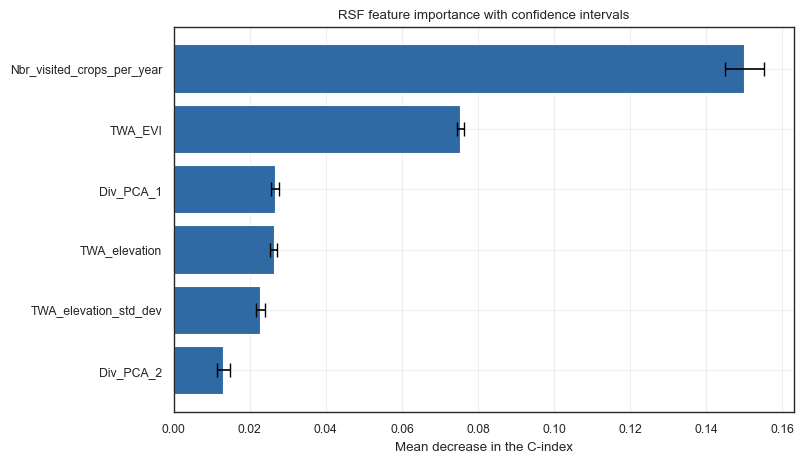

In [ ]:
# Plotting vimp
plt.figure(figsize=(8, 5))

plt.barh(vimp['Feature'], vimp['Mean importance'], xerr=vimp['Std. dev. importance'], 
         capsize=5, color='#2f6aa4', ecolor='black', linestyle='-')


plt.xlabel('Mean decrease in the C-index')
plt.title('RSF feature importance with confidence intervals')
plt.gca().invert_yaxis() 
plt.grid(True, alpha=0.3)

# plt.savefig(r'path',dpi=300,bbox_inches='tight')

plt.show()

In [ ]:
# export var imp table
# var_imp.to_csv(r'path\var_imp.csv')

# Appendix : Code used to retrieve EVI data

In [ ]:
break

In [ ]:
# function for evi

def get_evi(point,i_date,f_date):
  poi = ee.Geometry.Point(point.x, point.y)
  
  # select the modis product
  product = ee.ImageCollection('MODIS/061/MOD13A1')
  scale = 500 # resolution of product is 500 m

  evi = product.select('EVI').filterDate(i_date, f_date)

  mean_evi = evi.getRegion(poi, scale).getInfo()

  return mean_evi

dates have to be edited and the function repeated on ugdf

In [ ]:
# Initial date of interest (edit)
i_date = '2023-09-01'

# Final date of interest (exclusive).
f_date = '2023-10-15'

evi_list = []
c = 0

for i, row in ugdf.iterrows():
  #evi function
  data = get_evi(row.geometry, i_date, f_date)

  temp_df = pd.DataFrame(data[1:], columns=data[0])
  evi_list.append(temp_df['EVI'].mean())

  #counter
  c += 1
  if c % 10 == 0:  # Check if 'c' is a multiple of 10
      print(c)

  #delay
  # time.sleep(1)

# add evi values to gdf
ugdf['evi_sept'] = evi_list
ugdf['evi_sept'] = ugdf['evi_sept'] * 0.0001 #ratio from the MODIS user guide

In [ ]:
# exporting the csv of EO data
export_df = ugdf[['geometry','fpar_sept', 'evi_sept', 'fpar_jun','evi_jun','fpar_apr','evi_apr']]
# export_df.to_csv('path//eo-data_24.csv')